In [120]:
import math
import pydicom
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

### Load Image

In [121]:
DICOM_PATH = "images/DICOMOBJ/test-L"
IS_ROTATE = False 
# arrays = []

dicom_data = pydicom.dcmread(DICOM_PATH)
arr = dicom_data.pixel_array
if IS_ROTATE:
    arr = ndimage.rotate(arr, 90)

### Helper Functions

In [122]:
def inv_lut(arr: np.array):
    max_pixel = arr.max()
    min_pixel = arr.min()
    return max_pixel - arr + min_pixel

def display(arr: np.array, axis=False) :
    plt.imshow(arr, cmap="gray")
    plt.axis(axis)

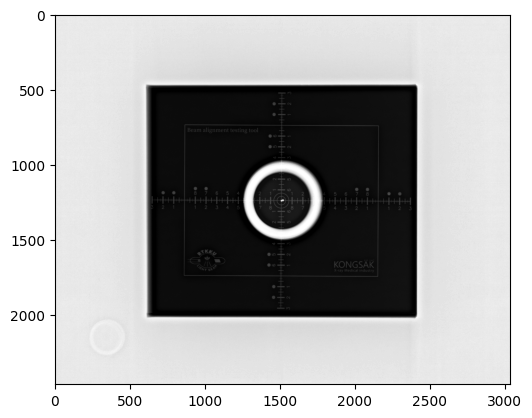

In [123]:
display(arr, True)

In [124]:
arr

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0, 14533, ..., 15404, 15069, 15296],
       ...,
       [    0,     0, 14861, ..., 14673, 15242, 14776],
       [    0,     0, 14668, ..., 15260, 14710, 15288],
       [    0,     0, 15517, ..., 14839, 14860, 14864]], dtype=uint16)

# Find Test-Tool

In [125]:
# assume crop if each size > 2,000 (not crop yet)
H, W = arr.shape
P = 0.24 # experimental number (Percent)
if (H*W) > (2000**2):
    arr = arr[int(H*P): int(H*(1-P)), int(W*P): int(W*(1-P))]
    H, W = arr.shape

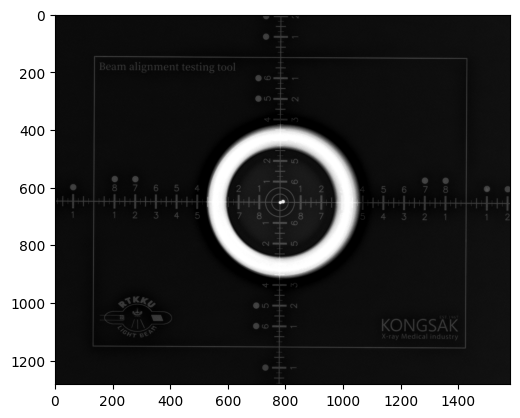

In [126]:
display(arr, True)

### Find Lines and Center of the Image

In [127]:
def most_common(focus_arr: np.array, axis=0) :
    """
    find most common pixel value in specific axis
    axis 0 = by col, axis 1 = by row
    return: most common pixel value
    """
    pixel_vals = np.argmax(focus_arr, axis=axis) # [b, w] color (if inv use argmin)
    unique_vals, counts = np.unique(pixel_vals, return_counts=True)
    most_common_idx = np.argmax(counts)
    pixel_val = unique_vals[most_common_idx]
    return pixel_val

- Find Center Line(Horizontal)

In [128]:
hp = int(0.2*H)
wp = int(0.06*W)

focus_l = arr[hp: H-hp, wp: wp*2]
focus_r = arr[hp: H-hp, W-(wp*2): W-wp]

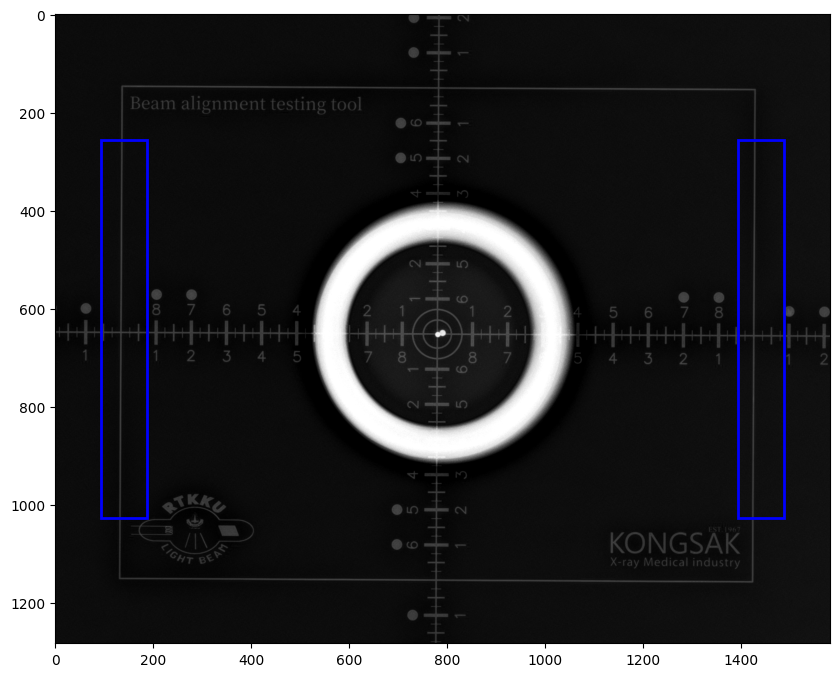

In [129]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(arr, cmap='gray')

# Top-Left(x, y), width, heigh
l_rec = patches.Rectangle((wp, hp), wp, H-2*hp, linewidth=2, edgecolor='blue', facecolor='none')
r_rec = patches.Rectangle((W-(wp*2), hp), (W-wp)-(W-(wp*2)), (H-hp)-hp, linewidth=2, edgecolor='blue', facecolor='none')
ax.add_patch(l_rec)
ax.add_patch(r_rec)

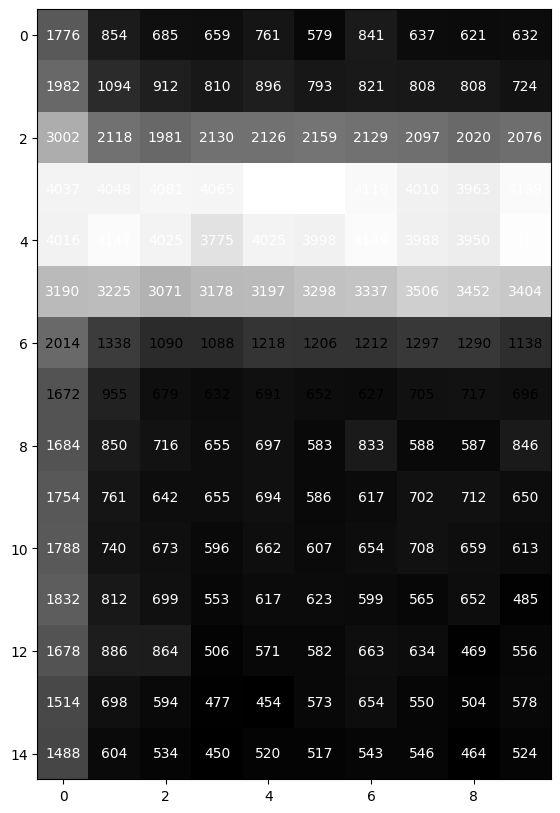

In [130]:
focus_v = arr[645: 660, 100: 110]

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(focus_v, cmap='gray')

# Annotate each pixel with its value
for i in range(focus_v.shape[0]): 
    for j in range(focus_v.shape[1]):  
        text = f"{focus_v[i, j]}"
        if i == 6 or i == 7 :
            c = "black"
        else: 
            c = "white"
        ax.text(j, i, text, ha="center", va="center", color=c, fontsize=10)

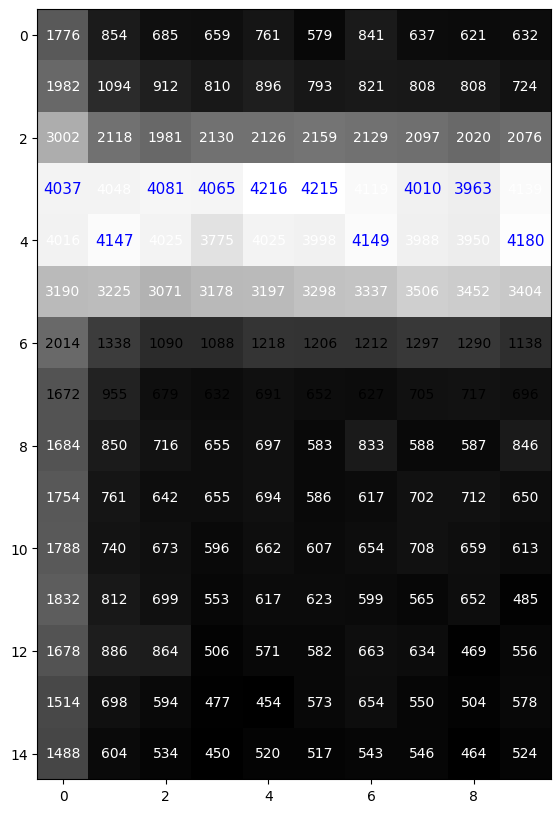

In [131]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(focus_v, cmap='gray')

max_c = np.argmax(focus_v, axis=0)
for i in range(focus_v.shape[0]): 
    for j in range(focus_v.shape[1]):  
        text = f"{focus_v[i, j]}"
        if i == 6 or i == 7 :
            c = "black"
        else: 
            c = "white"
        if i == max_c[j] :
            c = "blue"
            size = 11
        else :
            size = 10
        ax.text(j, i, text, ha="center", va="center", color=c, fontsize=size)

In [132]:
y1 = most_common(focus_l, axis=0) + hp # start at hp not 0
y2 = most_common(focus_r, axis=0) + hp 
y1, y2

(649, 656)

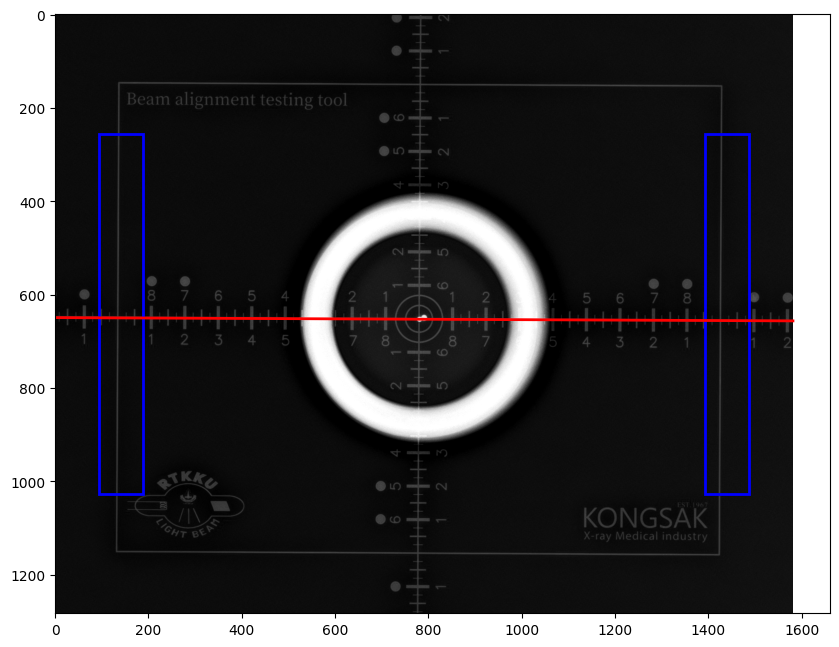

In [133]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(arr, cmap='gray')

# Top-Left(x, y), width, heigh
l_rec = patches.Rectangle((wp, hp), wp, H-2*hp, linewidth=2, edgecolor='blue', facecolor='none')
r_rec = patches.Rectangle((W-(wp*2), hp), (W-wp)-(W-(wp*2)), (H-hp)-hp, linewidth=2, edgecolor='blue', facecolor='none')
plt.plot([0, W], [y1, y2], linewidth=2, color="red")
ax.add_patch(l_rec)
ax.add_patch(r_rec)

In [134]:
def find_theta(x1, x2, y1, y2):
    """
    find theta from given width(x1, x2) and height(y1, y2)
    return: theta in degree
    """
    a = y2 - y1
    w = x2 - x1
    theta_r = math.atan(a/w)
    theta_d = math.degrees(theta_r)
    return theta_d

In [135]:
def find_center_line(arr: np.array):
    """
    find horizontal center line
    theta: alignment of the center line
    return (x1, y1), (x2, y2), (theta)
    """
    H, W = arr.shape
    hp = int(0.2*H)
    wp = int(0.06*W)

    # left point
    focus_l = arr[hp: H-hp, wp: wp*2]
    y1 = most_common(focus_l, axis=0) + hp
    
    # right point
    focus_r = arr[hp: H-hp, W-(wp*2): W-wp]
    y2 = most_common(focus_r, axis=0) + hp

    theta = find_theta(wp, W-(wp*2), y1, y2)
    
    return (0, y1), (W-1, y2), theta # W-1 for visualize not over blank

In [136]:
def draw_line(arr, x1, y1, x2, y2, axis=False, color="blue") :
    plt.imshow(arr, cmap="gray")
    plt.plot([x1, x2], [y1, y2], color=color, linewidth=1)
    plt.axis(axis)

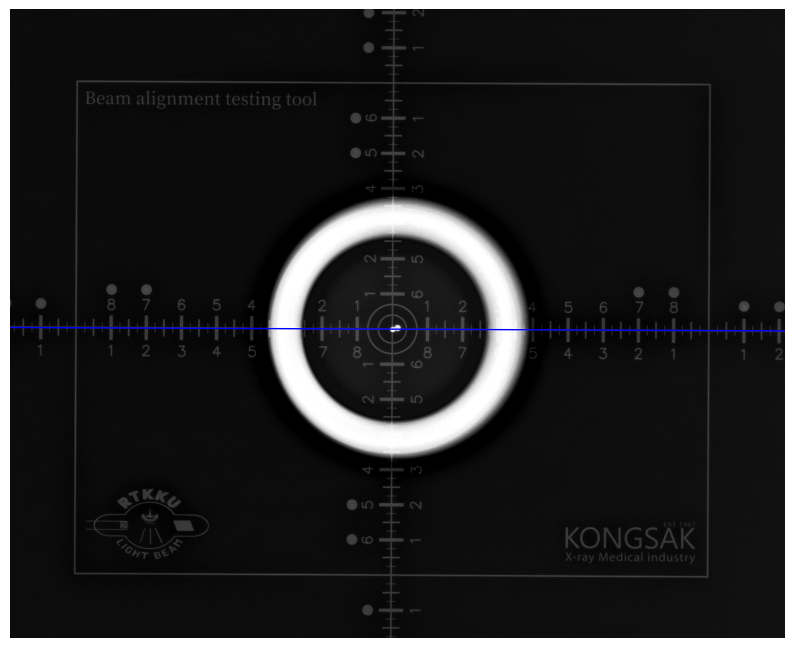

In [137]:
(x1, y1), (x2, y2), (theta_d) = find_center_line(arr)
plt.figure(figsize=(10, 10))
draw_line(arr, x1, y1, x2, y2)

In [138]:
theta_d

0.3087502497810308

### Rotate image by theta_d

In [139]:
# CCW rotate
rotate_img = ndimage.rotate(arr, theta_d, reshape=False, cval=arr.max())
h, w = rotate_img.shape

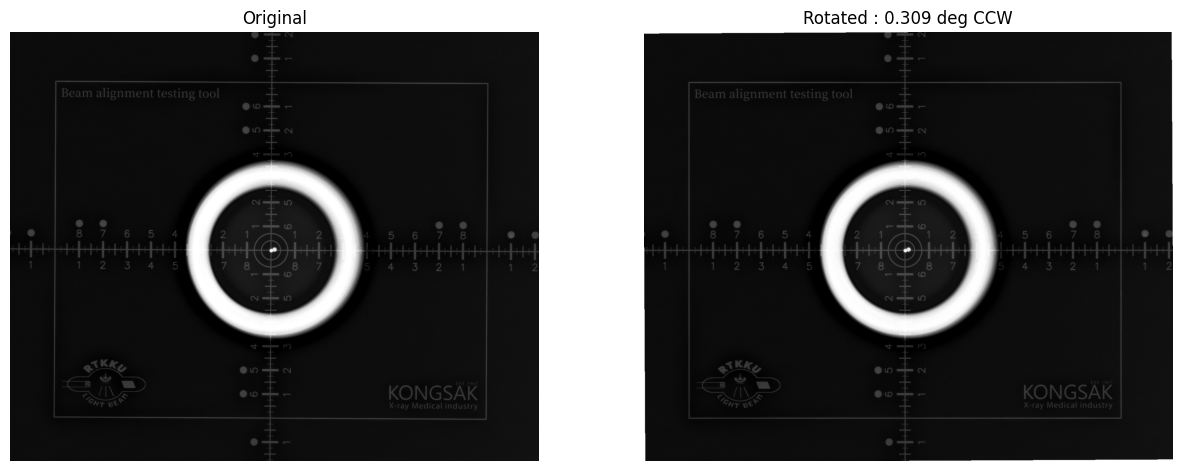

In [140]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta_d:.3f} deg CCW")
display(rotate_img)

# Find Lines in Rotated Image

In [141]:
def find_horizontal_lines(arr: np.array):
    """
    find horizontal lines[y-axis]
    return: top, center, bottom [y1, y2]
    """
    ypoints = []
    h, w = arr.shape
    hp = int(0.27*h)
    wp = int(0.07*w)
    offset = 20 # padding from rotating error (for top and bottom)

    # top line
    focus_l = arr[offset: hp, wp*2: wp*3]
    y1 = most_common(focus_l, axis=0) + offset
    focus_r = arr[offset: hp, w-(wp*3): w-(wp*2)]
    y2 = most_common(focus_l, axis=0) + offset
    ypoints.append((y1, y2))

    # center line
    (_, y1), (_, y2), _ = find_center_line(arr)
    ypoints.append((y1, y2))

    # bottom line
    focus_l = arr[h-hp: h-offset, wp*4: wp*5]
    y1 = most_common(focus_l, axis=0) + h-hp
    focus_r = arr[h-hp: h-offset, w-(wp*3): w-(wp*2)]
    y2 = most_common(focus_r, axis=0) + h-hp
    ypoints.append((y1, y2))

    return ypoints

In [142]:
ypoints = find_horizontal_lines(rotate_img)
ypoints

[(150, 150), (652, 652), (1154, 1154)]

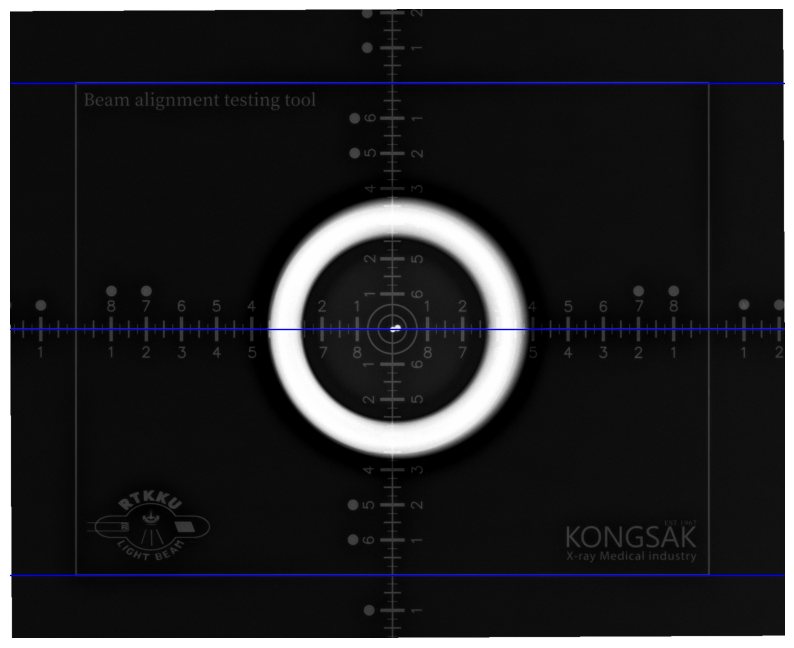

In [143]:
plt.figure(figsize=(10, 10))
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, 0, ypoints[idx][0], w-1, ypoints[idx][1])

In [144]:
def find_vertical_line(arr: np.array):
    """
    find vertical lines[x-axis]
    Return: (top(x1, x2), center(x1, x2), bottom(x1, x2))
    """
    xpoints = []
    h, w = arr.shape
    hp = int(0.05*h) # crop ratio
    wp = int(0.04*w)

    # left line
    focus_t = arr[hp*3: hp*7, wp: wp*6]
    x1 = most_common(focus_t, axis=1) + wp
    focus_b = arr[h-hp*7: h-hp*3, wp: wp*6]
    x2 = most_common(focus_b, axis=1) + wp
    xpoints.append((x1, x2))

    # right line
    focus_t = arr[hp*3: hp*7, w-(wp*6): w-wp]
    x1 = most_common(focus_t, axis=1) + w-(wp*6)
    focus_b = arr[h-hp*7: h-hp*3, w-(wp*6): w-wp]
    x2 = most_common(focus_b, axis=1) + w-(wp*6)
    xpoints.append((x1, x2))

    # center line
    hp = int(0.18*h)
    wp = int(0.2*w)

    focus_t = arr[hp: hp*2, wp*2: wp*3]
    x1 = most_common(focus_t, axis=1) + (wp*2)
    focus_b = arr[h-(hp*2): h-hp, wp*2: wp*3]
    x2 = most_common(focus_b, axis=1) + (wp*2)
    xpoints.append((x1, x2))

    # swap bottom and center in xpoints
    centerpoints = xpoints[-1]
    xpoints[-1] = xpoints[1]
    xpoints[1] = centerpoints
    return xpoints

In [145]:
xpoints = find_vertical_line(rotate_img)
xpoints

[(134, 134), (780, 780), (1425, 1425)]

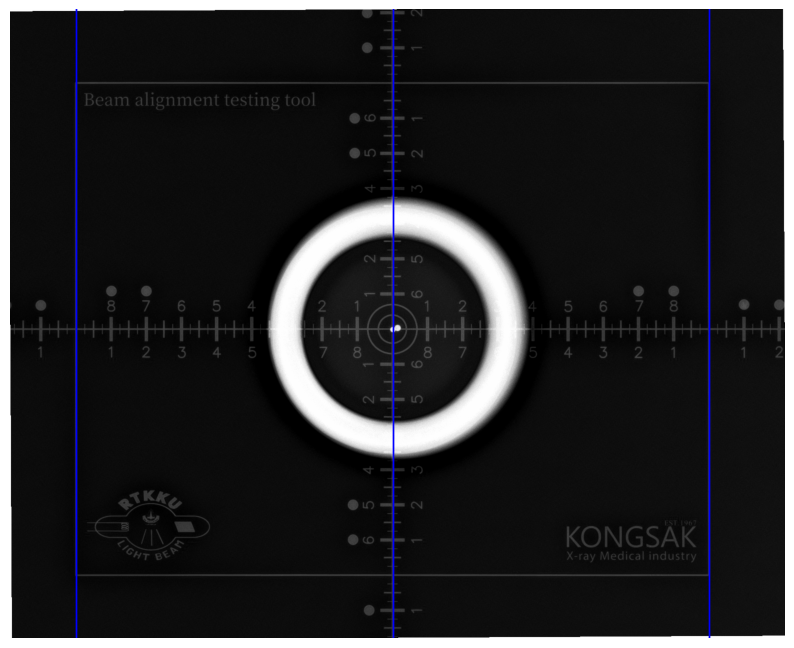

In [146]:
plt.figure(figsize=(10, 10))
for idx in range(len(xpoints)) : 
    draw_line(rotate_img, xpoints[idx], 0, xpoints[idx], h-1)

### Can optimize this
- TODO: select one value (y2, y1) -> y

In [147]:
xpoints = [round(np.mean(xpoints[idx])) for idx in range(3)]
ypoints = [round(np.mean(ypoints[idx])) for idx in range(3)]
xpoints, ypoints

([134, 780, 1425], [150, 652, 1154])

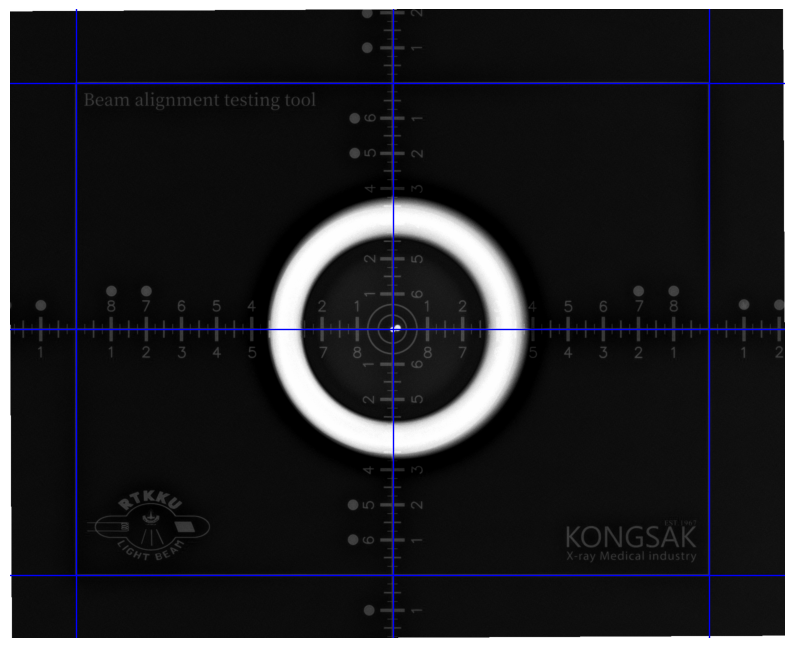

In [148]:
plt.figure(figsize=(10, 10))
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], 0, xpoints[idx], h-1)
    draw_line(rotate_img, 0, ypoints[idx], w-1, ypoints[idx])

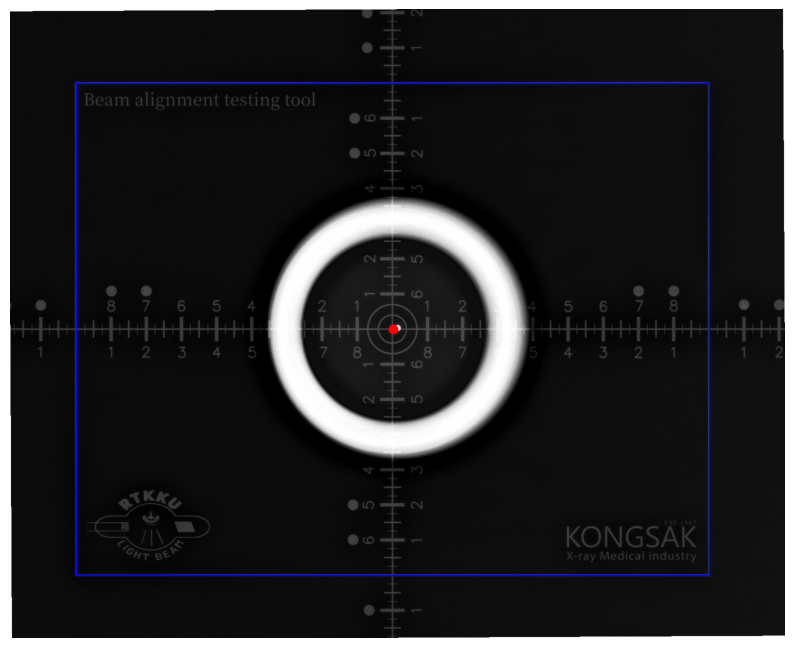

In [149]:
plt.figure(figsize=(10, 10))
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[idx], ypoints[-idx-1])
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[-idx-1], ypoints[idx])
plt.plot((xpoints[1]), (ypoints[1]), 'o', color="red")

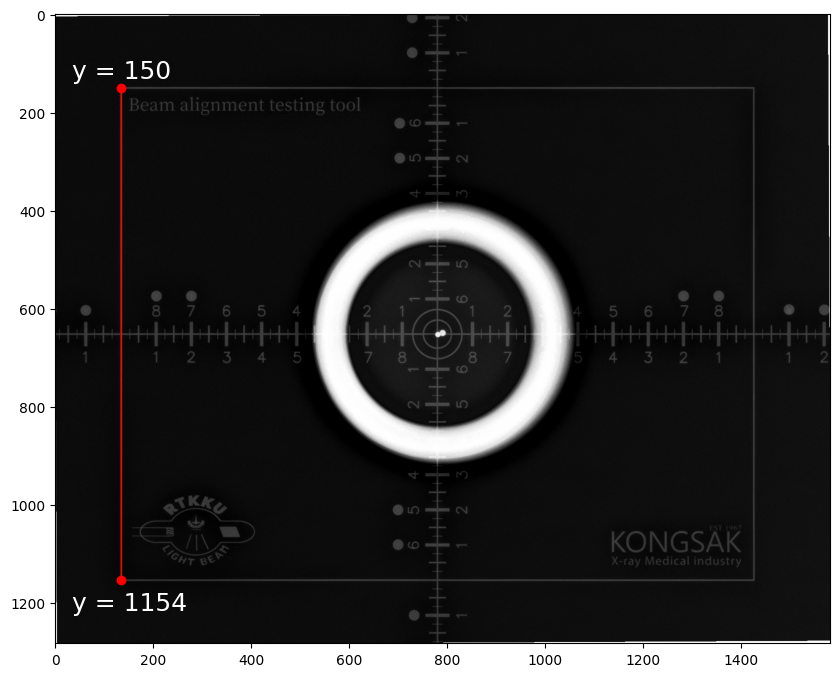

In [150]:
plt.figure(figsize=(10, 10))

draw_line(rotate_img, xpoints[0], ypoints[0], xpoints[0], ypoints[2], color="red")
plt.axis(True)
plt.text(xpoints[0]-100, ypoints[0]-20, f"y = {ypoints[0]}", fontsize = 18, color="white")
plt.plot((xpoints[0]), (ypoints[0]), 'o', color="red")
plt.text(xpoints[0]-100, ypoints[2]+60, f"y = {ypoints[2]}", fontsize = 18, color="white")
plt.plot((xpoints[0]), (ypoints[2]), 'o', color="red")

In [151]:
print(f"18cm [horizontal] equal: {xpoints[2]} - {xpoints[0]} = {xpoints[2] - xpoints[0]} pixels")
print(f"14cm [vertical] equal: {ypoints[2]} - {ypoints[0]} = {ypoints[2] - ypoints[0]} pixels")

18cm [horizontal] equal: 1425 - 134 = 1291 pixels
14cm [vertical] equal: 1154 - 150 = 1004 pixels


In [152]:
def pixel2cm(ypoints, number_pixels: int, is_rotate = False):
    """
    convert number of pixels to centimeter as aspect ratio
    """
    pixels_y = ypoints[2] - ypoints[0]
    cm_y = 14
    if is_rotate: cm_y = 18
    return round(number_pixels*cm_y/pixels_y, 2)

In [153]:
pixel2cm(ypoints, 1004)

14.0

In [154]:
def cm2pixel(ypoints, cm: float, is_rotate = False):
    """
    convert centimeter to number of pixels as aspect ratio
    """
    pixels_y = ypoints[2] - ypoints[0]
    cm_y = 14
    if is_rotate: cm_y = 18
    return round(pixels_y*cm/cm_y)

In [155]:
cm2pixel(ypoints, 14)

1004

## Field 14x18 cm

# Find the circles

In [156]:
one_cm_pixel = cm2pixel(ypoints, 1)
one_cm_pixel

72

In [157]:
xx = xpoints[1]-one_cm_pixel, xpoints[1]+one_cm_pixel
yy = ypoints[1]-one_cm_pixel, ypoints[1]+one_cm_pixel
xx, yy

((708, 852), (580, 724))

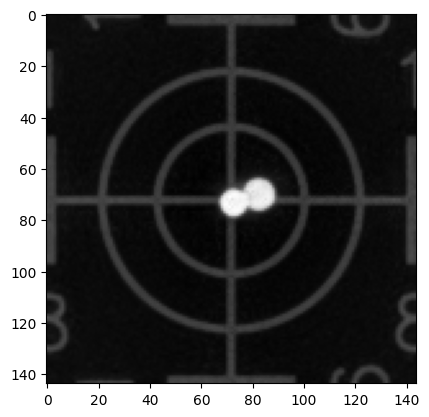

In [158]:
circle_focus = rotate_img[yy[0]: yy[1], xx[0]: xx[1]]
display(circle_focus, True)

In [159]:
inner_cir_r = cm2pixel(ypoints, 0.41)
outter_cir_r = cm2pixel(ypoints, 0.71)
inner_cir_r, outter_cir_r

(29, 51)

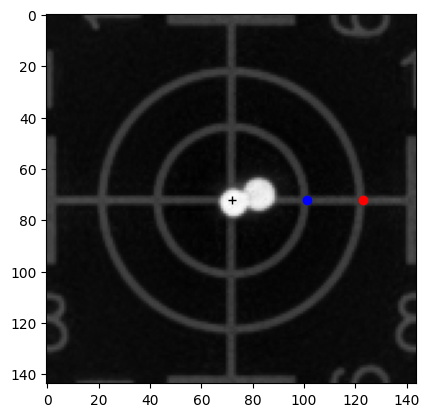

In [160]:
h = k = circle_focus.shape[0]//2
display(circle_focus, True)
plt.plot(h, k, "+", color="black")
plt.plot(h+inner_cir_r, k, "o", color="blue")
plt.plot(h+outter_cir_r, k, "o", color="red")

In [161]:
# (x-h)**2 + (y-k)**2 <= r**2
inner_points = []
outter_points = []
h = k = circle_focus.shape[0]//2
cols = rows = circle_focus.shape[0]
for col in range(cols):
    for row in range(rows):
        x, y = col, row
        if (x-h)**2 + (y-k)**2 == inner_cir_r**2 :
            inner_points.append([x, y])
        elif (x-h)**2 + (y-k)**2 == outter_cir_r**2:
            outter_points.append([x, y])

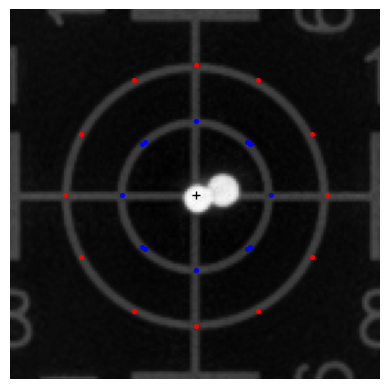

In [162]:
inner_points = np.array(inner_points)
outter_points = np.array(outter_points)

plt.plot(h, k, "+", color="black")
plt.scatter(outter_points[:, 0], outter_points[:, 1], s=7, c='red')
plt.scatter(inner_points[:, 0], inner_points[:, 1], s=7, c='blue')
display(circle_focus)

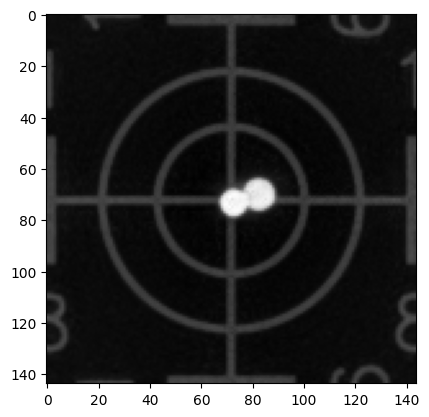

In [163]:
display(circle_focus, True)

In [164]:
# find edge of point
# split to 4 area -> find the fartest white in row, col then 
not_point_pixel_ts = 5
white_ts = int(np.percentile(circle_focus, q=99))

In [165]:
def find_center_circle_lines(arr: np.array):
    H, W = arr.shape
    hp = int(0.2*H)
    wp = int(0.06*W)

    # left point
    focus_l = arr[hp: H-hp, wp: wp*2]
    y1 = most_common(focus_l, axis=0) + hp
    # right point
    focus_r = arr[hp: H-hp, W-(wp*2): W-wp]
    y2 = most_common(focus_r, axis=0) + hp
    # avg y 
    y = math.ceil((y1 + y2)/2)

    # top point
    focus_l = arr[wp: wp*2, hp: H-hp]
    x1 = most_common(focus_l, axis=1) + hp
    # bottom point
    focus_r = arr[W-(wp*2): W-wp, hp: H-hp]
    x2 = most_common(focus_r, axis=1) + hp
    # avg x
    x = math.ceil((x1 + x2)/2)

    return x, y

In [166]:
xc, yc = find_center_circle_lines(circle_focus)
xc, yc

(72, 72)

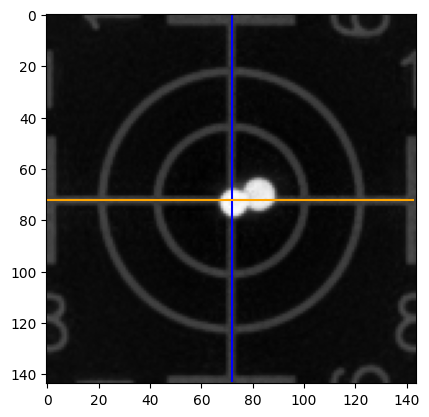

In [167]:
display(circle_focus, True)
plt.vlines([xc], ymin=0, ymax=rows-1, color="blue")
plt.hlines([yc], xmin=0, xmax=cols-1, color="orange")

In [168]:
top_left = circle_focus[:yc, :xc]
top_right = circle_focus[:yc , xc+1:] # doesn't count center
bottom_left = circle_focus[yc+1:, :xc]
bottom_right = circle_focus[yc+1:, xc+1:]

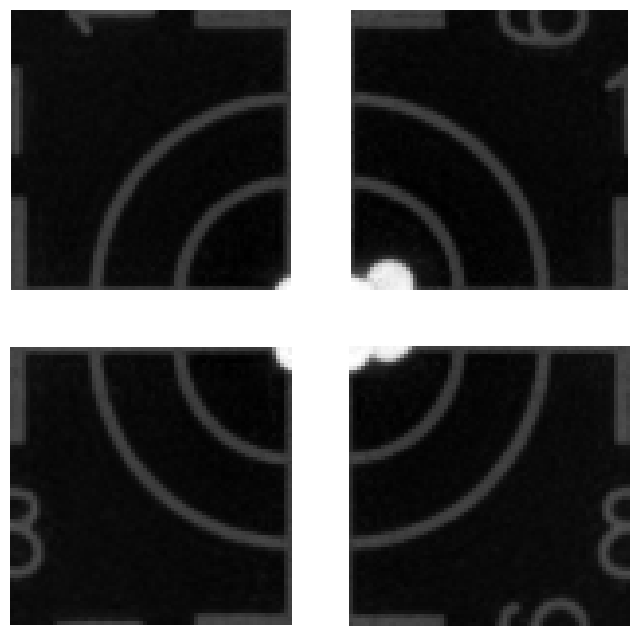

In [169]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
display(top_left)
plt.subplot(2, 2, 2)
display(top_right)
plt.subplot(2, 2, 3)
display(bottom_left)
plt.subplot(2, 2, 4)
display(bottom_right)

## Experiment

In [170]:
# top left: start nrows, ncols [optimize]
nrows, ncols = top_left.shape
fartest_col = [0, 0]
most_white_col = 0
not_white_r = 0
# find cols first
for row in range(nrows):
    print("row:", row)
    not_white_c = 0
    for col in range(ncols):
        new_row = nrows-row-1 # last row
        new_col = ncols-col-1 # last col
        p_val = top_left[new_row][new_col]
        print(col)
        if p_val >= white_ts:
            not_white_c = 0
            if col > fartest_col[1]:
                fartest_col[1] = col

        else:
            not_white_c += 1
            if not_white_c >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_r += 1 if col == not_point_pixel_ts-1 else 0
                print(not_white_r)
                break
    
    # break for row
    if not_white_r >= not_point_pixel_ts:
        break
    print()

row: 0
0
1
2
3
4
5
6
7
8
pause
0

row: 1
0
1
2
3
4
5
6
7
pause
0

row: 2
0
1
2
3
4
5
6
pause
0

row: 3
0
1
2
3
4
pause
1

row: 4
0
1
2
3
4
pause
2

row: 5
0
1
2
3
4
pause
3

row: 6
0
1
2
3
4
pause
4

row: 7
0
1
2
3
4
pause
5


In [171]:
fartest_col

[0, 3]

In [172]:
fartest_row = [0, 0]
most_white_row = 0
not_white_c = 0
# find cols first
for col in range(ncols):
    print("col:", col)
    not_white_r = 0
    for row in range(nrows):
        new_row = nrows-row-1 # last row
        new_col = ncols-col-1 # last col
        p_val = top_left[new_row][new_col]
        print(row)
        if p_val >= white_ts:
            not_white_r = 0
            if row > fartest_row[0]:
                fartest_row[0] = row

        else:
            not_white_r += 1
            if not_white_r >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_c += 1 if row == not_point_pixel_ts-1 else 0
                print(not_white_c)
                break
    
    # break for row
    if not_white_c >= not_point_pixel_ts:
        break
    print()

col: 0
0
1
2
3
4
5
6
7
pause
0

col: 1
0
1
2
3
4
5
6
7
pause
0

col: 2
0
1
2
3
4
5
6
pause
0

col: 3
0
1
2
3
4
5
pause
0

col: 4
0
1
2
3
4
pause
1

col: 5
0
1
2
3
4
pause
2

col: 6
0
1
2
3
4
pause
3

col: 7
0
1
2
3
4
pause
4

col: 8
0
1
2
3
4
pause
5


In [173]:
fartest_row, fartest_col

([2, 0], [0, 3])

In [174]:
# find most white col for row
row_idx, col_idx = fartest_row[0], fartest_col[1] # range
fartest_row[1] = np.argmax(top_left[nrows-row_idx-1, ncols-col_idx-1:][::-1])
fartest_row

[2, 0]

In [175]:
# find most white row for col
fartest_col[0] = np.argmax(top_left[nrows-row_idx-1:, ncols-col_idx-1][::-1])
fartest_col

[0, 3]

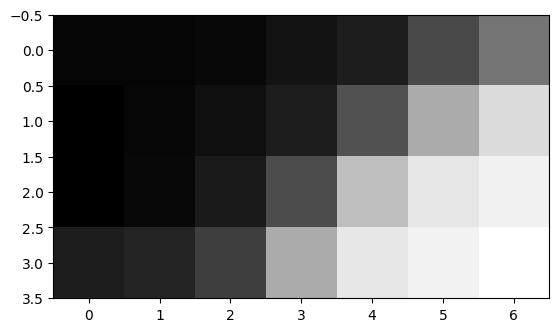

In [176]:
display(top_left[68:, 65: ], True)

In [177]:
top_left[68:, 65: ]

array([[ 2021,  2022,  2214,  2803,  3402,  5928,  8411],
       [ 1752,  2143,  2600,  3424,  6379, 11514, 14224],
       [ 1720,  2228,  3237,  6104, 12545, 14846, 15499],
       [ 3388,  3714,  5267, 11471, 14912, 15541, 16304]], dtype=uint16)

In [178]:
fartest_col, fartest_row

([0, 3], [2, 0])

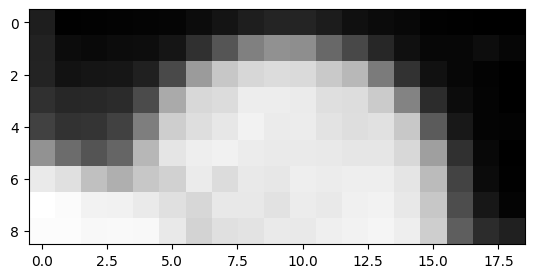

In [179]:
display(top_right[63:, :19], True)

In [180]:
white_ts

9729

In [181]:
np.set_printoptions(linewidth=500)
for i, v in enumerate(top_right[63:, :19]):
    print(9-i, v)

9 [3541 1932 2022 2084 2118 2162 2545 3016 3582 3967 3932 3466 2806 2477 2322 2026 1943 1892 1913]
8 [3804 2533 2375 2571 2589 3048 4535 6622 9002 9949 9778 7692 5876 4085 2796 2288 2284 2597 2229]
7 [ 3811  2879  3076  3136  3712  5983 10512 12929 13857 14117 14005 13056 12092  8719  4678  2854  2284  2070  1875]
6 [ 4548  4055  4096  4303  6065 11349 13894 14105 15064 15067 14943 14299 14200 13155  9206  4314  2568  2114  1915]
5 [ 5543  4675  4846  5510  8909 13313 14250 14717 15364 14953 15004 14532 14210 14379 13001  6950  3243  2103  2054]
4 [ 9989  7879  6566  7512 12056 14598 15102 15283 15029 14900 14911 14864 14648 14675 13877 10732  4599  2350  1863]
3 [14887 14367 12539 11593 12961 13524 14963 14094 14834 14712 15146 15001 15141 15095 14625 12281  5620  2497  1951]
2 [16091 15826 15358 15285 14869 14337 13859 14774 14787 14455 15018 14842 15207 15363 14780 12955  6174  3191  2140]
1 [15909 15897 15679 15716 15666 14841 13691 14334 14501 14918 14862 15196 15350 15506 15091 1

In [182]:
# top right: start nrows, 0 [optimize]
nrows, ncols = top_right.shape
fartest_col = [0, 0]
most_white_col = 0
not_white_r = 0
# find cols first
for row in range(nrows):
    print("row:", row)
    not_white_c = 0
    for col in range(ncols):
        new_row = nrows-row-1 # last row
        new_col = col # first col
        p_val = top_right[new_row][new_col]
        print(col)
        if p_val >= white_ts:
            not_white_c = 0
            if col > fartest_col[1]:
                fartest_col[1] = col

        else:
            not_white_c += 1
            if not_white_c >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_r += 1 if col == not_point_pixel_ts-1 else 0
                print(not_white_r)
                break
    
    # break for row
    if not_white_r >= not_point_pixel_ts:
        break
    print()

row: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
pause
0

row: 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
pause
0

row: 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
pause
0

row: 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
pause
0

row: 4
0
1
2
3
4
pause
1

row: 5
0
1
2
3
4
pause
2

row: 6
0
1
2
3
4
pause
3

row: 7
0
1
2
3
4
pause
4

row: 8
0
1
2
3
4
pause
5


In [183]:
fartest_col

[0, 15]

In [184]:
fartest_row = [0, 0]
most_white_row = 0
not_white_c = 0
# find cols first
for col in range(ncols):
    print("col:", col)
    not_white_r = 0
    for row in range(nrows):
        new_row = nrows-row-1 # last row
        new_col = col # first col
        p_val = top_right[new_row][new_col]
        print(row)
        if p_val >= white_ts:
            not_white_r = 0
            if row > fartest_row[0]:
                fartest_row[0] = row

        else:
            not_white_r += 1
            if not_white_r >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_c += 1 if row == not_point_pixel_ts-1 else 0
                print(not_white_c)
                break
    
    # break for row
    if not_white_c >= not_point_pixel_ts:
        break
    print()

col: 0
0
1
2
3
4
5
6
7
8
pause
0

col: 1
0
1
2
3
4
5
6
7
pause
0

col: 2
0
1
2
3
4
5
6
7
pause
0

col: 3
0
1
2
3
4
5
6
7
pause
0

col: 4
0
1
2
3
4
5
6
7
8
pause
0

col: 5
0
1
2
3
4
5
6
7
8
9
10
pause
0

col: 6
0
1
2
3
4
5
6
7
8
9
10
11
pause
0

col: 7
0
1
2
3
4
5
6
7
8
9
10
11
pause
0

col: 8
0
1
2
3
4
5
6
7
8
9
10
11
pause
0

col: 9
0
1
2
3
4
5
6
7
8
9
10
11
12
pause
0

col: 10
0
1
2
3
4
5
6
7
8
9
10
11
12
pause
0

col: 11
0
1
2
3
4
5
6
7
8
9
10
11
pause
0

col: 12
0
1
2
3
4
5
6
7
8
9
10
11
pause
0

col: 13
0
1
2
3
4
5
6
7
8
9
10
pause
0

col: 14
0
1
2
3
4
5
6
7
8
9
pause
0

col: 15
0
1
2
3
4
5
6
7
8
pause
0

col: 16
0
1
2
3
4
pause
1

col: 17
0
1
2
3
4
pause
2

col: 18
0
1
2
3
4
pause
3

col: 19
0
1
2
3
4
pause
4

col: 20
0
1
2
3
4
pause
5


In [185]:
fartest_col, fartest_row

([0, 15], [7, 0])

In [186]:
# find most white col for row
row_idx, col_idx = fartest_row[0], fartest_col[1] # range
fartest_row[1] = np.argmax(top_right[nrows-row_idx-1, :col_idx+1])
fartest_row

[7, 9]

In [187]:
# find most white row for col
fartest_col[0] = np.argmax(top_right[nrows-row_idx-1:, col_idx][::-1])
fartest_col

[0, 15]

In [188]:
bottom_left.shape

(71, 72)

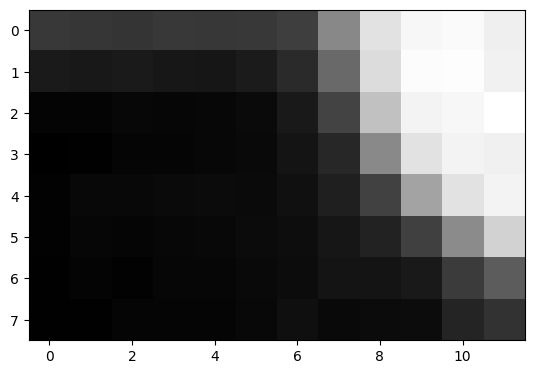

In [189]:
display(bottom_left[:8, 60:], True)

In [190]:
for i, v in enumerate(bottom_left[:8, 60:]):
    print(i, v)

0 [ 4321  4204  4193  4399  4278  4367  4692  9131 14480 15738 15885 15233]
1 [ 2568  2444  2569  2393  2319  2646  3509  7272 14082 15997 16092 15375]
2 [ 1226  1228  1454  1360  1428  1585  2512  4971 12518 15492 15711 16223]
3 [  982  1070  1306  1328  1416  1526  2180  3325  9144 14462 15519 15306]
4 [ 1146  1497  1496  1629  1669  1612  1957  2855  4908 10791 14473 15566]
5 [ 1160  1344  1318  1433  1487  1642  1810  2327  3042  4806  9285 13525]
6 [1080 1223 1154 1365 1342 1558 1745 2184 2191 2474 4519 6483]
7 [1077 1083 1298 1326 1305 1512 1921 1522 1640 1708 3156 4001]


In [191]:
# bottom left: start 0, ncols [optimize]
nrows, ncols = bottom_left.shape
fartest_col = [0, 0]
most_white_col = 0
not_white_r = 0
# find cols first
for row in range(nrows):
    print("row:", row)
    not_white_c = 0
    for col in range(ncols):
        new_row = row # first row
        new_col = ncols-col-1 # last col
        p_val = bottom_left[new_row][new_col]
        print(col)
        if p_val >= white_ts:
            not_white_c = 0
            if col > fartest_col[1]:
                fartest_col[1] = col

        else:
            not_white_c += 1
            if not_white_c >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_r += 1 if col == not_point_pixel_ts-1 else 0
                print(not_white_r)
                break
    
    # break for row
    if not_white_r >= not_point_pixel_ts:
        break
    print()

row: 0
0
1
2
3
4
5
6
7
8
pause
0

row: 1
0
1
2
3
4
5
6
7
8
pause
0

row: 2
0
1
2
3
4
5
6
7
8
pause
0

row: 3
0
1
2
3
4
5
6
7
pause
0

row: 4
0
1
2
3
4
5
6
7
pause
0

row: 5
0
1
2
3
4
5
pause
0

row: 6
0
1
2
3
4
pause
1

row: 7
0
1
2
3
4
pause
2

row: 8
0
1
2
3
4
pause
3

row: 9
0
1
2
3
4
pause
4

row: 10
0
1
2
3
4
pause
5


In [192]:
fartest_col

[0, 3]

In [193]:
fartest_row = [0, 0]
most_white_row = 0
not_white_c = 0
# find cols first
for col in range(ncols):
    print("col:", col)
    not_white_r = 0
    for row in range(nrows):
        new_row = row # first row
        new_col = ncols-col-1 # last col
        p_val = bottom_left[new_row][new_col]
        print(row)
        if p_val >= white_ts:
            not_white_r = 0
            if row > fartest_row[0]:
                fartest_row[0] = row

        else:
            not_white_r += 1
            if not_white_r >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_c += 1 if row == not_point_pixel_ts-1 else 0
                print(not_white_c)
                break
    
    # break for row
    if not_white_c >= not_point_pixel_ts:
        break
    print()

col: 0
0
1
2
3
4
5
6
7
8
9
10
pause
0

col: 1
0
1
2
3
4
5
6
7
8
9
pause
0

col: 2
0
1
2
3
4
5
6
7
8
9
pause
0

col: 3
0
1
2
3
4
5
6
7
pause
0

col: 4
0
1
2
3
4
pause
1

col: 5
0
1
2
3
4
pause
2

col: 6
0
1
2
3
4
pause
3

col: 7
0
1
2
3
4
pause
4

col: 8
0
1
2
3
4
pause
5


In [194]:
fartest_row

[5, 0]

In [195]:
# find most white col for row
row_idx, col_idx = fartest_row[0], fartest_col[1] # range
fartest_row[1] = np.argmax(bottom_left[row_idx, ncols-col_idx-1:][::-1])
fartest_row

[5, 0]

In [196]:
# find most white row for col
fartest_col[0] = np.argmax(bottom_left[:row_idx+1, ncols-col_idx-1])
fartest_col

[0, 3]

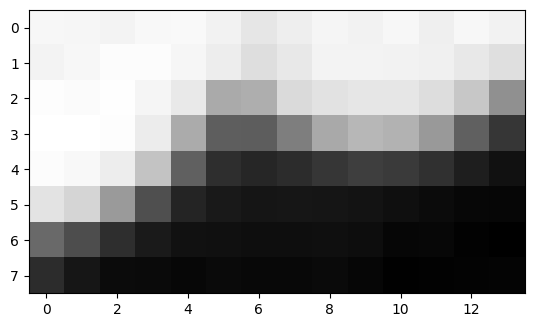

In [197]:
display(bottom_right[:8, :14], True)

In [198]:
for i, v in enumerate(bottom_right[:8, :14]):
    print(i, v)

0 [15507 15456 15324 15589 15637 15263 14552 15001 15390 15258 15526 15066 15522 15244]
1 [15371 15503 15801 15836 15473 14984 14103 14683 15353 15294 15239 15153 14666 14172]
2 [15895 15746 15913 15440 14713 11143 11379 13869 14306 14567 14559 14045 12774  9639]
3 [15958 16012 15847 14909 11219  6805  6731  8652 11087 11867 11582 10185  6901  4522]
4 [15808 15607 14959 12596  6923  4093  3604  3995  4548  5006  4764  4159  3140  2408]
5 [14429 13561 10199  5955  3565  2893  2668  2680  2654  2544  2287  2064  1842  1785]
6 [7407 5843 4050 2941 2437 2346 2218 2230 2321 2171 1762 1844 1549 1417]
7 [3971 2694 2095 1992 1869 2002 1899 1892 2040 1798 1510 1532 1645 1682]


In [199]:
# bottom left: start 0, 0 [optimize]
nrows, ncols = bottom_right.shape
fartest_col = [0, 0]
most_white_col = 0
not_white_r = 0
# find cols first
for row in range(nrows):
    print("row:", row)
    not_white_c = 0
    for col in range(ncols):
        new_row = row # first row
        new_col = col # first col
        p_val = bottom_right[new_row][new_col]
        print(col)
        if p_val >= white_ts:
            not_white_c = 0
            if col > fartest_col[1]:
                fartest_col[1] = col

        else:
            not_white_c += 1
            if not_white_c >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_r += 1 if col == not_point_pixel_ts-1 else 0
                print(not_white_r)
                break
    
    # break for row
    if not_white_r >= not_point_pixel_ts:
        break
    print()

row: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
pause
0

row: 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
pause
0

row: 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
pause
0

row: 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
pause
0

row: 4
0
1
2
3
4
5
6
7
8
pause
0

row: 5
0
1
2
3
4
5
6
7
pause
0

row: 6
0
1
2
3
4
pause
1

row: 7
0
1
2
3
4
pause
2

row: 8
0
1
2
3
4
pause
3

row: 9
0
1
2
3
4
pause
4

row: 10
0
1
2
3
4
pause
5


In [200]:
fartest_col

[0, 15]

In [201]:
fartest_row = [0, 0]
most_white_row = 0
not_white_c = 0
# find cols first
for col in range(ncols):
    print("col:", col)
    not_white_r = 0
    for row in range(nrows):
        new_row = row # first row
        new_col = col # last col
        p_val = bottom_right[new_row][new_col]
        print(row)
        if p_val >= white_ts:
            not_white_r = 0
            if row > fartest_row[0]:
                fartest_row[0] = row

        else:
            not_white_r += 1
            if not_white_r >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_c += 1 if row == not_point_pixel_ts-1 else 0
                print(not_white_c)
                break
    
    # break for row
    if not_white_c >= not_point_pixel_ts:
        break
    print()

col: 0
0
1
2
3
4
5
6
7
8
9
10
pause
0

col: 1
0
1
2
3
4
5
6
7
8
9
10
pause
0

col: 2
0
1
2
3
4
5
6
7
8
9
10
pause
0

col: 3
0
1
2
3
4
5
6
7
8
9
pause
0

col: 4
0
1
2
3
4
5
6
7
8
pause
0

col: 5
0
1
2
3
4
5
6
7
pause
0

col: 6
0
1
2
3
4
5
6
7
pause
0

col: 7
0
1
2
3
4
5
6
7
pause
0

col: 8
0
1
2
3
4
5
6
7
8
pause
0

col: 9
0
1
2
3
4
5
6
7
8
pause
0

col: 10
0
1
2
3
4
5
6
7
8
pause
0

col: 11
0
1
2
3
4
5
6
7
8
pause
0

col: 12
0
1
2
3
4
5
6
7
pause
0

col: 13
0
1
2
3
4
5
6
pause
0

col: 14
0
1
2
3
4
5
6
pause
0

col: 15
0
1
2
3
4
5
pause
0

col: 16
0
1
2
3
4
pause
1

col: 17
0
1
2
3
4
pause
2

col: 18
0
1
2
3
4
pause
3

col: 19
0
1
2
3
4
pause
4

col: 20
0
1
2
3
4
pause
5


In [202]:
fartest_row

[5, 0]

In [203]:
# find most white col for row
row_idx, col_idx = fartest_row[0], fartest_col[1] # range
fartest_row[1] = np.argmax(bottom_right[row_idx, :col_idx+1])
fartest_row

[5, 0]

In [204]:
fartest_col[0] = np.argmax(bottom_right[:row_idx+1, col_idx])
fartest_col

[0, 15]

## Solution

In [205]:
def find_fartest_white(focus_arr: np.array, first_row: bool, first_col: bool):
    nrows, ncols = focus_arr.shape
    fartest_col = 0
    not_white_r = 0
    # find cols first
    for row in range(nrows):
        not_white_c = 0
        for col in range(ncols):
            new_row = row if first_row else nrows-row-1
            new_col = col if first_col else ncols-col-1 
            p_val = focus_arr[new_row][new_col]
            if p_val >= white_ts:
                not_white_c = 0
                if col > fartest_col:
                    fartest_col = col
            else:
                not_white_c += 1
                if not_white_c >= not_point_pixel_ts:
                    # break for row
                    not_white_r += 1 if col == not_point_pixel_ts-1 else 0
                    break
        # break for row
        if not_white_r >= not_point_pixel_ts:
            break

    fartest_row = 0
    not_white_c = 0
    # find cols 
    for col in range(ncols):
        not_white_r = 0
        for row in range(nrows):
            new_row = row if first_row else nrows-row-1
            new_col = col if first_col else ncols-col-1 
            p_val = focus_arr[new_row][new_col]
            if p_val >= white_ts:
                not_white_r = 0
                if row > fartest_row:
                    fartest_row = row

            else:
                not_white_r += 1
                if not_white_r >= not_point_pixel_ts:
                    # break for row
                    not_white_c += 1 if row == not_point_pixel_ts-1 else 0
                    break
        
        # break for row
        if not_white_c >= not_point_pixel_ts:
            break

    return fartest_row, fartest_col

In [206]:
def distance(x, y):
    return math.sqrt(x**2 + y**2)

In [207]:
def fartest_q(q_array, visualize=True):
    """
    q_array = [top_left, top_right, bottom_left, bottom_right]
    fartest point quadrate 
    return fartest quadrate, [row, col]
    """
    fartest_q = 0
    fartest = 0
    row_idx, col_idx = 0, 0
    config = [(False, False), (False, True), (True, False), (True, True)] # is first row, col
    for i, q in enumerate(q_array):
        x, y = find_fartest_white(q, config[i][0], config[i][1])
        d = distance(x, y)
        if d >= fartest:
            fartest = d
            fartest_q = i
            row_idx, col_idx = x, y

    fartest_point = [[row_idx, 0], [0, col_idx]]
    nrows, ncols = q_array[fartest_q].shape
    # find corner of the point: find p_max col for row, ...
    if fartest_q == 0:
        # max_col for row
        fartest_point[0][1] = np.argmax(
            q_array[0][nrows-row_idx-1, ncols-col_idx-1:][::-1]
        )
        # max_row for col
        fartest_point[1][0] = np.argmax(
            q_array[0][nrows-row_idx-1:, ncols-col_idx-1][::-1]
        )
    
    elif fartest_q == 1:
        # max_col for row
        fartest_point[0][1] = np.argmax(
            q_array[1][nrows-row_idx-1, :col_idx+1]
        )
        # max_row for col
        fartest_point[1][0] = np.argmax(
            q_array[1][nrows-row_idx-1:, col_idx][::-1]
        )
    
    elif fartest_q == 2:
        # max_col for row
        fartest_point[0][1] = np.argmax(
            q_array[2][row_idx, ncols-col_idx-1:][::-1]
        )
        # max_row for col
        fartest_point[1][0] = np.argmax(
            q_array[2][:row_idx+1, ncols-col_idx-1]
        )

    elif fartest_q == 3:
        # max_col for row
        fartest_point[0][1] = np.argmax(
            q_array[2][row_idx, :col_idx+1]
        )
        # max_row for col
        fartest_point[1][0] = np.argmax(
            q_array[2][:row_idx+1, col_idx]
        )

    return fartest_q, fartest_point

In [208]:
q, fartest_point = fartest_q([top_left, top_right, bottom_left, bottom_right])
[row, col] = fartest_point
q, row, col

(1, [7, 9], [0, 15])

In [209]:
def center_point(fartest_point, fartest_q, q, xc, yc):
    """
    defined center point from fartest point
    return row, col
    """
    x = fartest_point[0][1]
    y = fartest_point[1][0]

    # 2point(row, col)
    x1 = fartest_point[1][1]
    y1 = fartest_point[0][0]
    
    nrows, ncols = fartest_q.shape
    if q == 0:
        x = xc-1 - x
        x1 = xc-1 - x1
        y = yc-1 - y
        y1 = yc-1 - y1
    elif q == 1:
        x = xc+1 + x
        x1 = xc+1 + x1
        y = yc-1 - y
        y1 = yc-1 - y1
    elif q == 2:
        x = xc-1 + x
        x1 = xc-1 + x1
        y = yc+1 + y
        y1 = yc+1 + y1
    elif q == 3:
        x = xc+1 + x
        x1 = xc+1 + x1
        y = yc+1 + y
        y1 = yc+1 + y1
    
    # center, T/B, L/R
    return [y, x], [y1, x], [y, x1]

In [210]:
[dev_y, dev_x], [y1, x1], [y2, x2] = center_point(fartest_point, top_right, 1, xc, yc)
dev_y, dev_x, [y1, x1], [y2, x2]

(71, 82, [64, 82], [71, 88])

In [211]:
def check_angle(h, k, x, y, r1, r2):
    """
    check the point the which angle
    """
    if (x-h)**2 + (y-k)**2 <= r1**2:
        return "1.5"
    elif (x-h)**2 + (y-k)**2 <= r2**2:
        return "3.0"
    else:
        return ">3.0"

Text(0.5, 1.0, 'angle: 1.5')

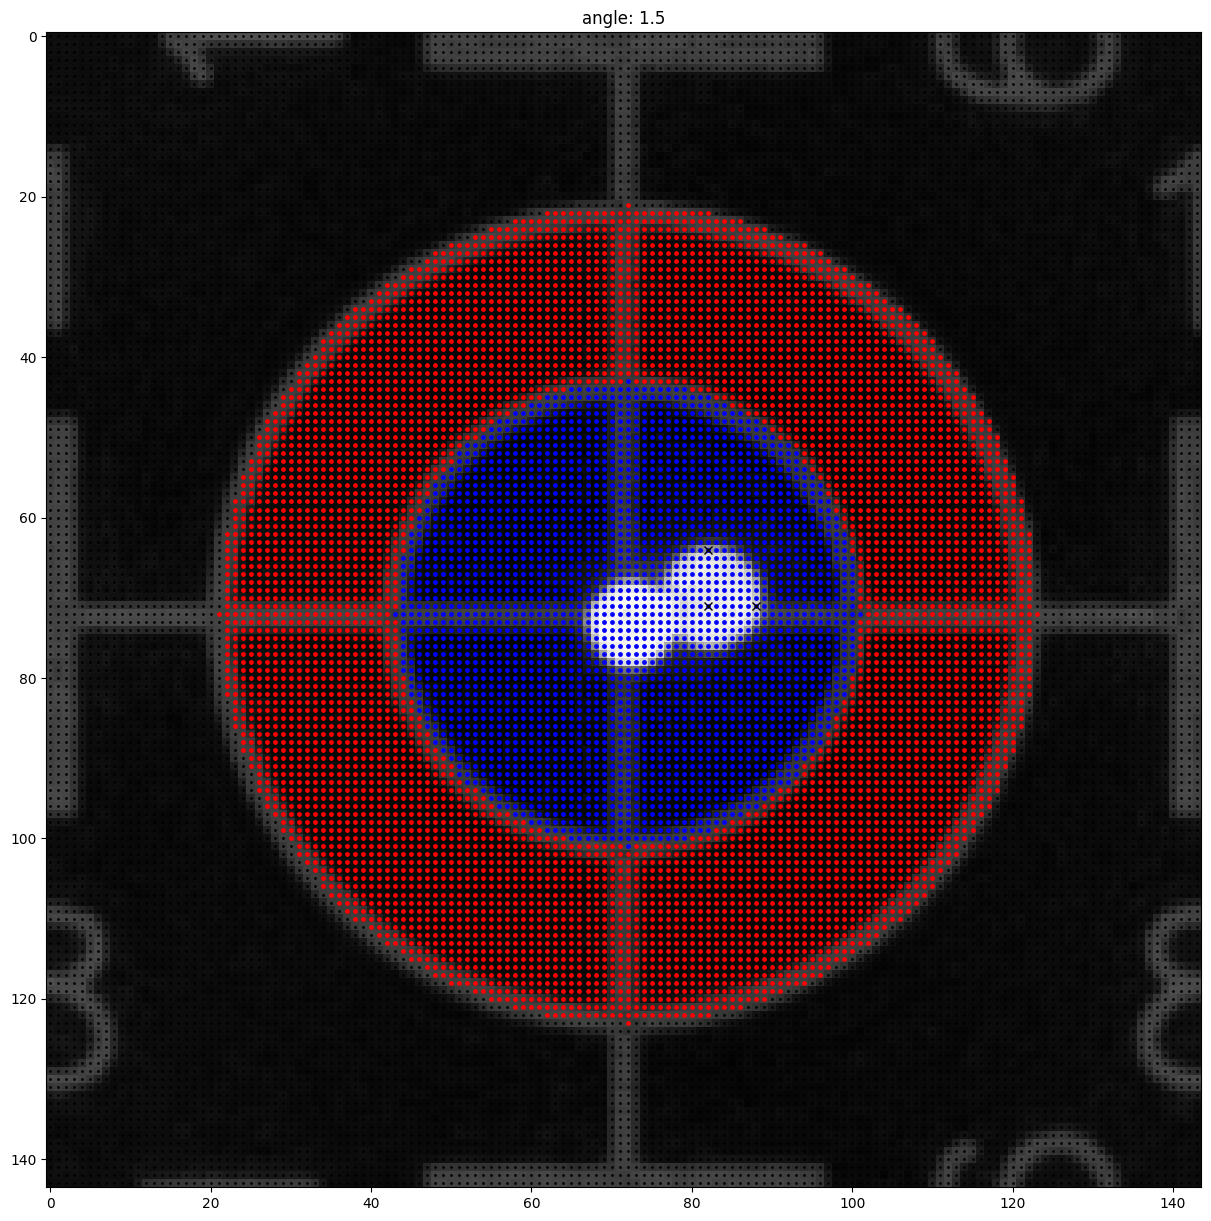

In [212]:
# (x-h)**2 + (y-k)**2 <= r**
inner_points = []
outter_points = []
out = []
h, k = xc, yc
cols = rows = circle_focus.shape[0]
for col in range(cols):
    for row in range(rows):
        x, y = col, row
        if (x-h)**2 + (y-k)**2 <= inner_cir_r**2 :
            inner_points.append([x, y])
        elif (x-h)**2 + (y-k)**2 <= outter_cir_r**2:
            outter_points.append([x, y])
        else:
            out.append([x, y])

inner_points = np.array(inner_points)
outter_points = np.array(outter_points)
out = np.array(out)

plt.figure(figsize=(15, 15))
display(circle_focus, True)
plt.scatter(outter_points[:, 0], outter_points[:, 1], s=6, c='red')
plt.scatter(inner_points[:, 0], inner_points[:, 1], s=6, c='blue')
plt.scatter(out[:, 0], out[:, 1], s=1, c='black')
plt.plot(dev_x, dev_y, "x", c="black")
plt.plot(x1, y1, "x", c="black")
plt.plot(x2, y2, "x", c="black")

point_angle = check_angle(h, k, dev_x, dev_y, inner_cir_r, outter_cir_r)
plt.title(f"angle: {point_angle}")

# Find the Edges
- in 14x18cm size

In [213]:
DICOM_PATH = "images/DICOMOBJ/test-S"
IS_ROTATE = False 

dicom_data = pydicom.dcmread(DICOM_PATH)
arr2 = dicom_data.pixel_array
if IS_ROTATE:
    arr2 = ndimage.rotate(arr2, 90)

H, W = arr2.shape
P = 0.24 # experimental number (Percent)
if (H*W) > (2000**2):
    arr2 = arr2[int(H*P): int(H*(1-P)), int(W*P): int(W*(1-P))]
    H, W = arr2.shape

rotate_img2 = ndimage.rotate(arr2, theta_d, reshape=False, cval=arr2.max())
h, w = rotate_img2.shape

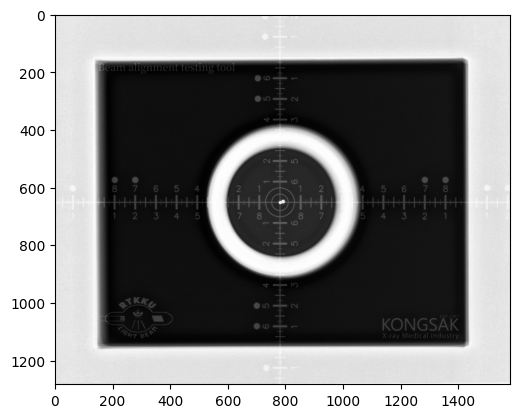

In [214]:
display(rotate_img2, True)

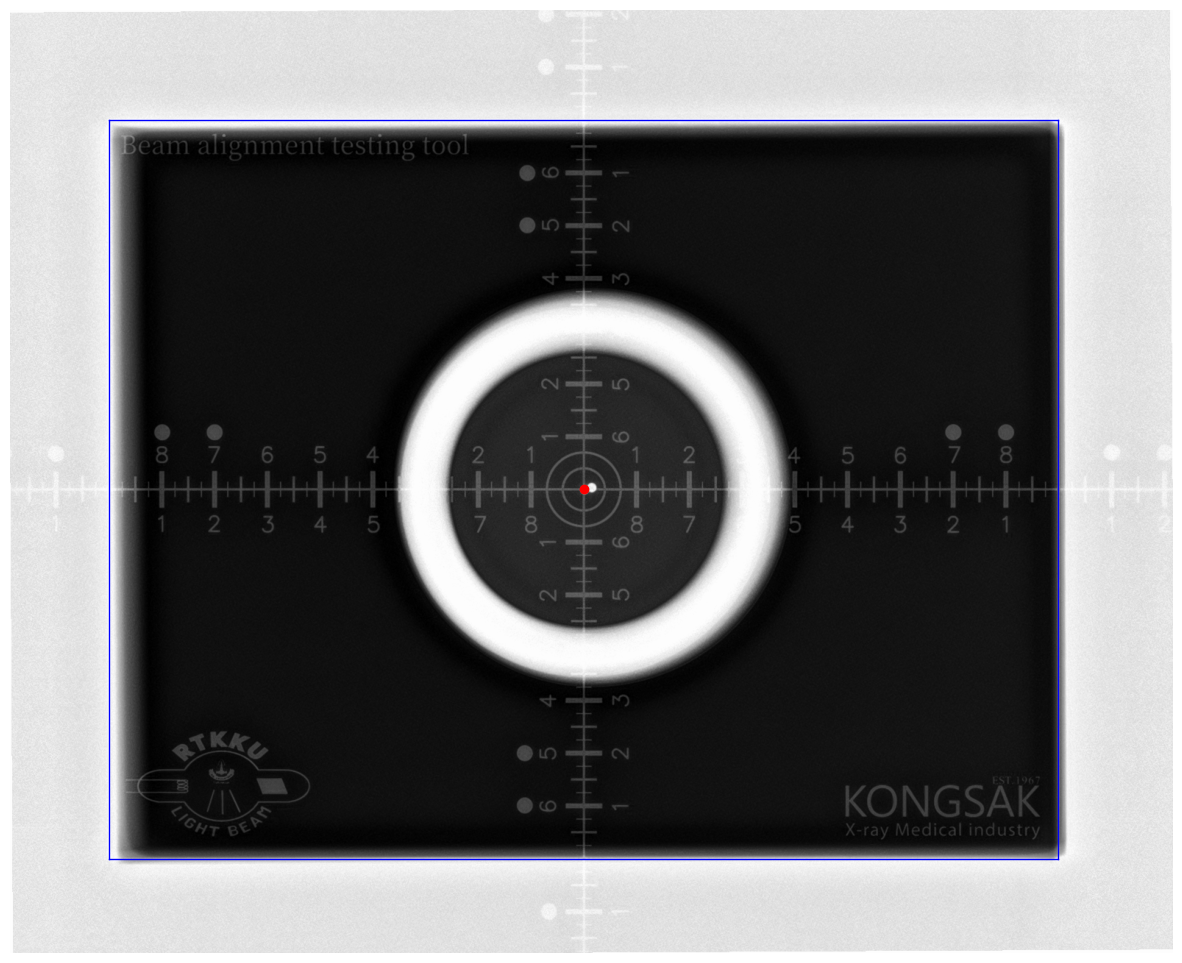

In [215]:
plt.figure(figsize=(15, 15))
for idx in range(len(ypoints)) : 
    draw_line(rotate_img2, xpoints[idx], ypoints[idx], xpoints[idx], ypoints[-idx-1])
    draw_line(rotate_img2, xpoints[idx], ypoints[idx], xpoints[-idx-1], ypoints[idx])
plt.plot((xpoints[1]), (ypoints[1]), 'o', color="red")

### Left

In [216]:
# find y1 distance[left]
# estimate line between top and center: to escepe center black line
center_p = xpoints[1], (ypoints[0] + ypoints[1])//2
left_p = xpoints[0], (ypoints[0]+ypoints[1])//2
center_p, left_p

((780, 401), (134, 401))

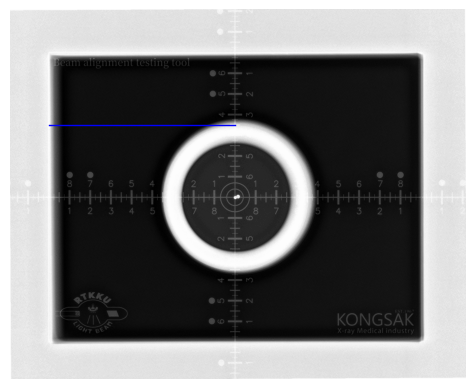

In [217]:
draw_line(rotate_img2, center_p[0], center_p[1], left_p[0], left_p[1])

In [218]:
# box
crop_ratio = 0.2
add_horizontal_crop = int((left_p[0]*(1-crop_ratio)) + (center_p[0]*crop_ratio)) - left_p[0]
add_vertical_crop = int(h*0.04)
add_horizontal_crop, add_vertical_crop

(129, 51)

In [219]:
top_left_point = max(left_p[0]-add_horizontal_crop, 0), left_p[1]-add_vertical_crop  # prevent negative 
bottom_right_point = left_p[0]+add_horizontal_crop, left_p[1]+add_vertical_crop
top_left_point, bottom_right_point

((5, 350), (263, 452))

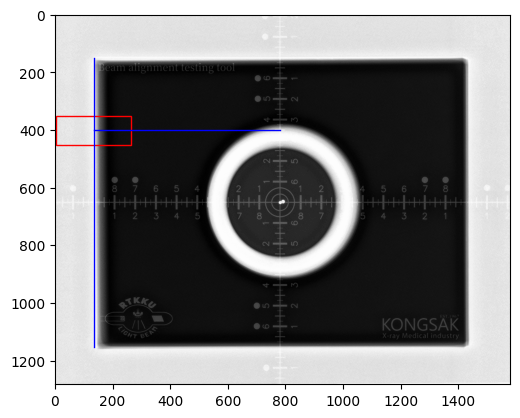

In [220]:
# crop left area
from matplotlib.patches import Rectangle

ax = plt.gca()
display(rotate_img2, True)
(x, y), w, h = top_left_point, bottom_right_point[0]-top_left_point[0], bottom_right_point[1]-top_left_point[1]
plt.plot([xpoints[0], xpoints[0]], [ypoints[0], ypoints[2]], color='blue', linewidth=1)
plt.plot([center_p[0], left_p[0]], [center_p[1], left_p[1]], color='blue', linewidth=1)
rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r',facecolor='none')
ax.add_patch(rect)

Text(0.5, 1.0, 'Large Field')

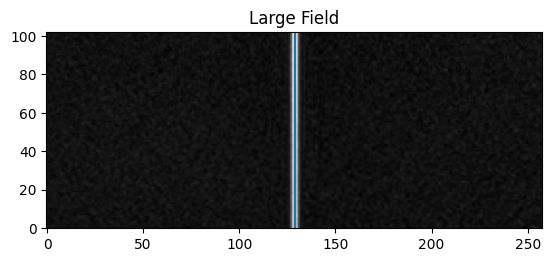

In [221]:
# plot with test-L line
left_focus = rotate_img[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]
display(left_focus, True)
plt.plot([xpoints[0]-top_left_point[0], xpoints[0]-top_left_point[0]], [0, bottom_right_point[1]-top_left_point[1]])
plt.ylim([0, bottom_right_point[1]-top_left_point[1]]);
plt.title("Large Field")

Text(0.5, 1.0, '14x18cm Field')

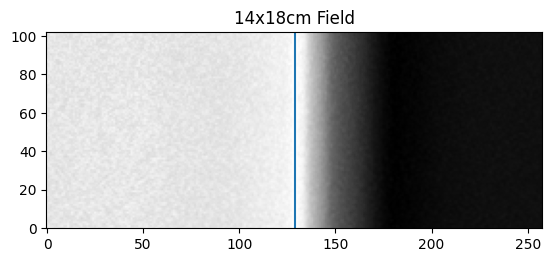

In [222]:
# plot with test-S line
left_focus = rotate_img2[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]
display(left_focus, True)
plt.plot([xpoints[0]-top_left_point[0], xpoints[0]-top_left_point[0]], [0, bottom_right_point[1]-top_left_point[1]])
plt.ylim([0, bottom_right_point[1]-top_left_point[1]]);
plt.title("14x18cm Field")

### Edge detection: Central Difference Method

#### Experiment

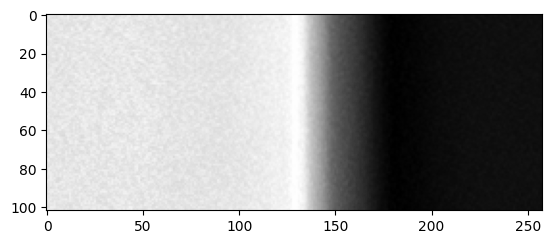

In [223]:
display(left_focus, True)

Text(0, 0.5, 'Pixel-Value')

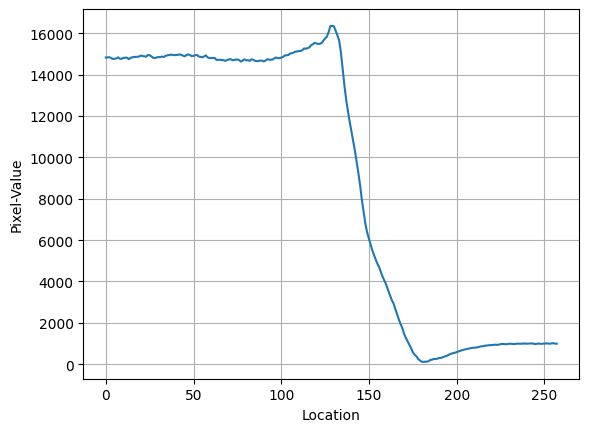

In [224]:
plt.plot(np.mean(left_focus, axis=0))
plt.grid(True)
plt.xlabel("Location")
plt.ylabel("Pixel-Value")

In [225]:
# fininte difference by cols
pixels = left_focus.copy()
nrows, ncols = pixels.shape
edge_pixels = [] 
h = 1 # distance between the two pixels being compared
for r_idx in range(nrows) :
    edge_pixels_col = []
    for c_idx in range(h, ncols-h) : # ncols-1: becuase c_idx+1 use
        # covert to int: not overflow from negative value
        first_val = int(pixels[r_idx][c_idx-h])
        second_val = int(pixels[r_idx][c_idx+h])
        diff_val = np.abs(first_val - second_val) / (2 * h)
        edge_pixels_col.append(round(diff_val))
    edge_pixels.append(edge_pixels_col)

edge_pixels = np.array(edge_pixels)

Text(0, 0.5, 'Pixel-Value-Difference')

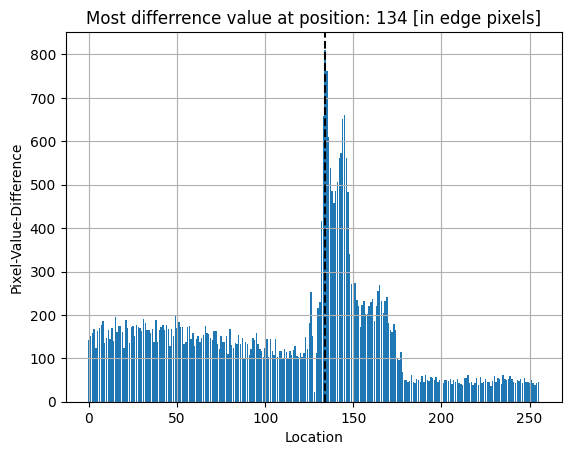

In [226]:
avg_edge = np.median(edge_pixels, axis=0)
max_pos = np.argmax(avg_edge)
plt.bar(np.arange(ncols-(h*2)), avg_edge)
plt.axvline(max_pos, c="black", linestyle="--")
plt.grid(True)
plt.title(f"Most differrence value at position: {max_pos} [in edge pixels]")
plt.xlabel("Location")
plt.ylabel("Pixel-Value-Difference")

In [227]:
# take avg of most diff edge
ts = np.percentile(avg_edge, q=95)
first_pos, last_pos = None, None
# find first pos
for pos, val in enumerate(avg_edge) :
    if val >= ts :
        first_pos = pos
        break

# find last pos
n = len(avg_edge)
for pos, val in enumerate(avg_edge[::-1]) :
    if val >= ts :
        last_pos = n-pos-1
        break

ts, first_pos, last_pos

(484.0, 133, 146)

Text(0, 0.5, 'Pixel-Value-Difference')

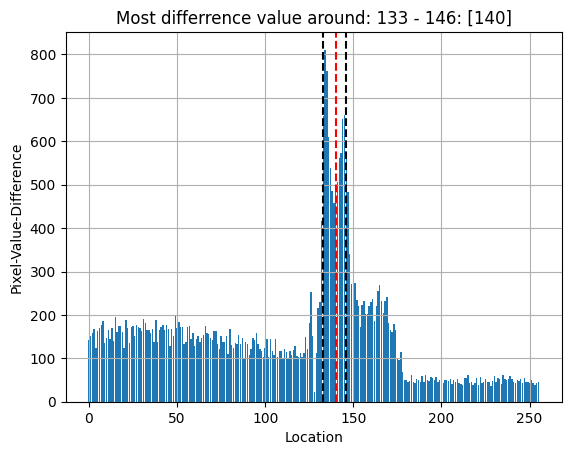

In [228]:
avg_edge = np.median(edge_pixels, axis=0)
max_pos = np.argmax(avg_edge)
avg_pos = round((first_pos + last_pos) / 2)
plt.bar(np.arange(ncols-(h*2)), avg_edge)
plt.axvline(first_pos, c="black", linestyle="--")
plt.axvline(last_pos, c="black", linestyle="--")
plt.axvline(avg_pos, c="red", linestyle="--")
plt.grid(True)
plt.title(f"Most differrence value around: {first_pos} - {last_pos}: [{avg_pos}]")
plt.xlabel("Location")
plt.ylabel("Pixel-Value-Difference")

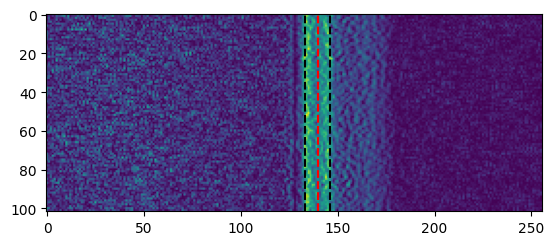

In [229]:
plt.imshow(edge_pixels)
plt.axvline(first_pos, c="black", linestyle="--")
plt.axvline(last_pos, c="black", linestyle="--")
plt.axvline(avg_pos, c="red", linestyle="--")

In [230]:
edge_pixels.shape, pixels.shape # not same shape so not same position

((102, 256), (102, 258))

Text(0, 0.5, 'Pixel-Value')

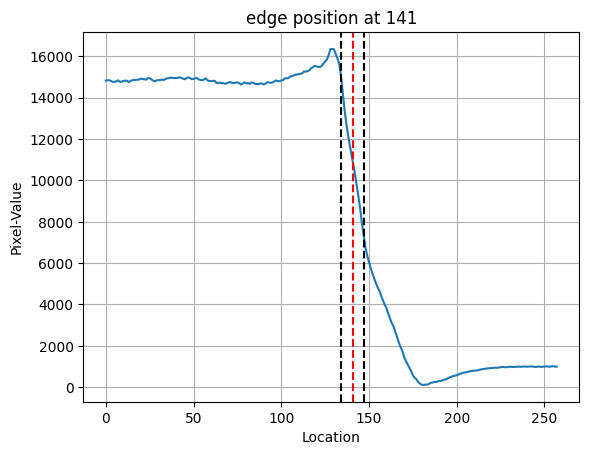

In [231]:
# make it same position from edge to the pixels
plt.plot(np.mean(pixels, axis=0))
f_pos = first_pos + 1
l_pos = last_pos + 1
edge_pos = avg_pos + 1
plt.title(f"edge position at {edge_pos}")
plt.axvline(x=edge_pos, linestyle="--", c="red")
plt.axvline(x=f_pos, linestyle="--", c="k")
plt.axvline(x=l_pos, linestyle="--", c="k")
plt.grid(True)
plt.xlabel("Location")
plt.ylabel("Pixel-Value")

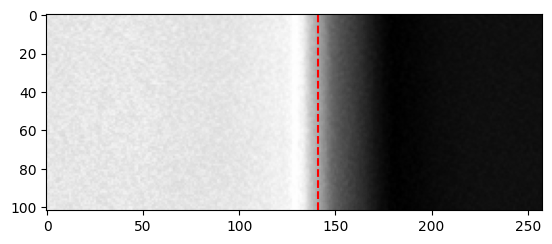

In [232]:
plt.imshow(pixels, cmap="gray")
plt.axvline(x=edge_pos, linestyle="--", c="red")

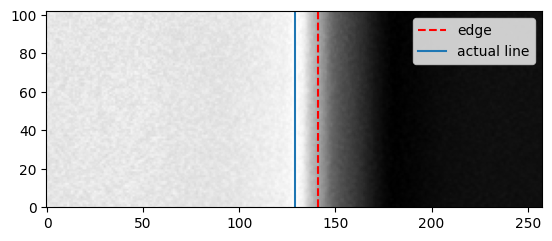

In [233]:
plt.imshow(pixels, cmap="gray")
plt.axvline(x=edge_pos, linestyle="--", c="red", label="edge")
plt.plot([xpoints[0]-top_left_point[0], xpoints[0]-top_left_point[0]], [0, bottom_right_point[1]-top_left_point[1]], label="actual line")
plt.ylim([0, bottom_right_point[1]-top_left_point[1]]);
plt.legend()

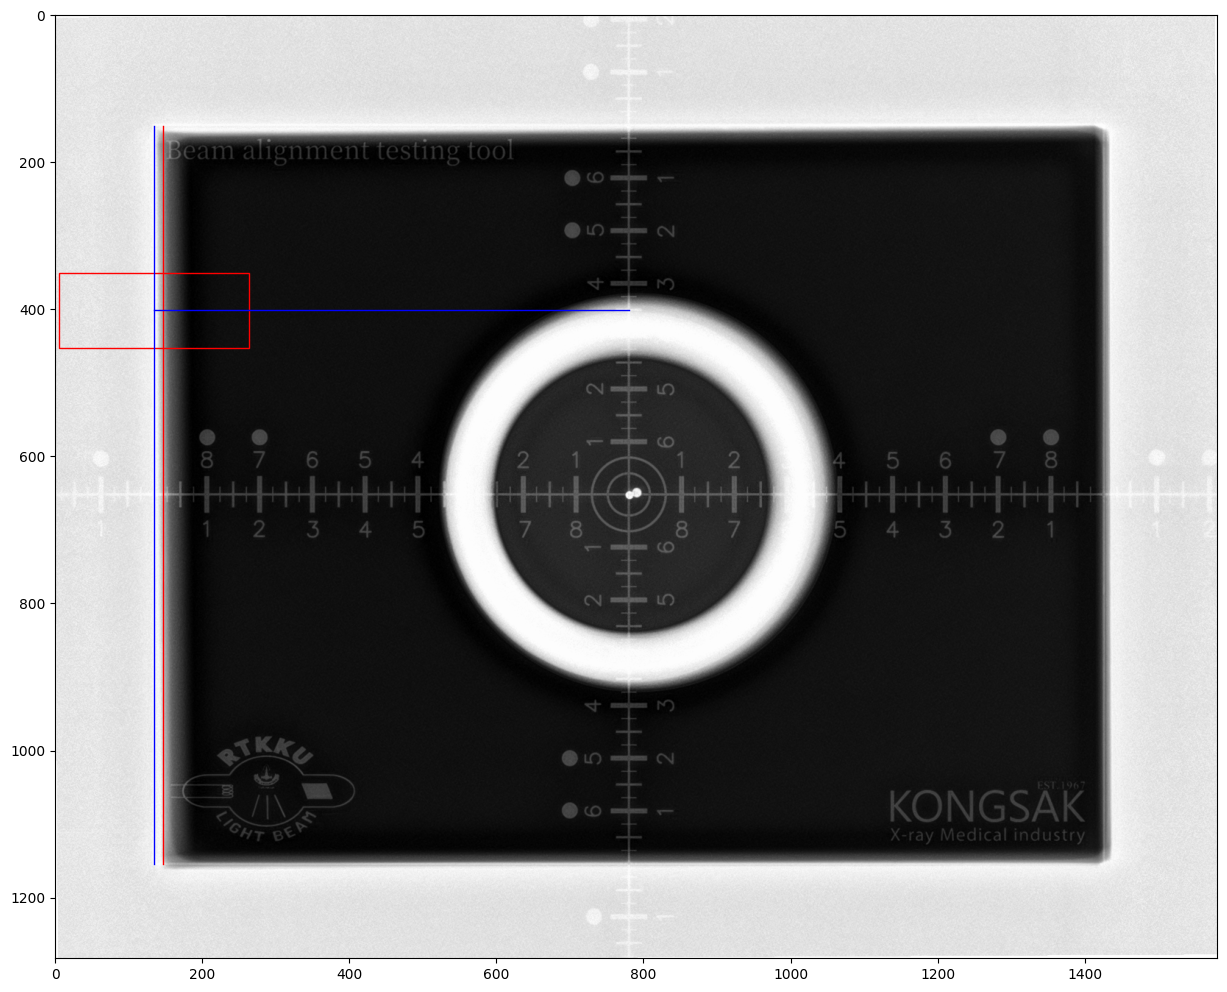

In [234]:
# move to entire image
edge_pos = edge_pos + top_left_point[0] # add start x

plt.figure(figsize=(15, 15))
ax = plt.gca()
display(rotate_img2, True)
(x, y), w, h = top_left_point, bottom_right_point[0]-top_left_point[0], bottom_right_point[1]-top_left_point[1]
plt.plot([xpoints[0], xpoints[0]], [ypoints[0], ypoints[2]], color='blue', linewidth=1)
plt.plot([edge_pos, edge_pos], [ypoints[0], ypoints[2]], color='red', linewidth=1)
plt.plot([center_p[0], left_p[0]], [center_p[1], left_p[1]], color='blue', linewidth=1)
rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r',facecolor='none')
ax.add_patch(rect)

#### Solution

In [347]:
# find box of each xs, ys
def boxs_position(xpoints, ypoints, arr):
    """
    return box position(top-left(x, y), bottom-right(x, y))
    Left, Right, Top, Bottom
    """
    h, w = arr.shape
    pos = []
    rotate_err = int(0.01*w)
    
    # Left-Right
    add_horizontal_crop = int(w*0.1)
    add_vertical_crop = int(h*0.06)
    # Left
    left_p = xpoints[0], (ypoints[0]+ypoints[1])//2
    top_left_point = max(left_p[0]-add_horizontal_crop, rotate_err), left_p[1]-add_vertical_crop  # prevent negative 
    bottom_right_point = left_p[0]+add_horizontal_crop, left_p[1]+add_vertical_crop
    pos.append([top_left_point, bottom_right_point])

    # Right
    right_p = xpoints[2], (ypoints[0]+ypoints[1])//2
    top_left_point = right_p[0]-add_horizontal_crop, right_p[1]-add_vertical_crop  
    bottom_right_point = min(right_p[0]+add_horizontal_crop, w-rotate_err-1), right_p[1]+add_vertical_crop
    pos.append([top_left_point, bottom_right_point])

    # Top-Bottom
    # Top
    top_p = (xpoints[1]+xpoints[2])//2, ypoints[0]
    top_left_point = top_p[0]-add_vertical_crop, max(top_p[1]-add_horizontal_crop, rotate_err)
    bottom_right_point = top_p[0]+add_vertical_crop, top_p[1]+add_horizontal_crop
    pos.append([top_left_point, bottom_right_point])

    # Bottom
    bottop_p = (xpoints[1]+xpoints[2])//2, ypoints[2]
    top_left_point = bottop_p[0]-add_vertical_crop, bottop_p[1]-add_horizontal_crop
    bottom_right_point = bottop_p[0]+add_vertical_crop, min(bottop_p[1]+add_horizontal_crop, h-rotate_err-1)
    pos.append([top_left_point, bottom_right_point])

    return pos

In [348]:
v = boxs_position(xpoints, ypoints, rotate_img2)
v

[[(15, 325), (292, 477)],
 [(1267, 325), (1565, 477)],
 [(1026, 15), (1178, 308)],
 [(1026, 996), (1178, 1267)]]

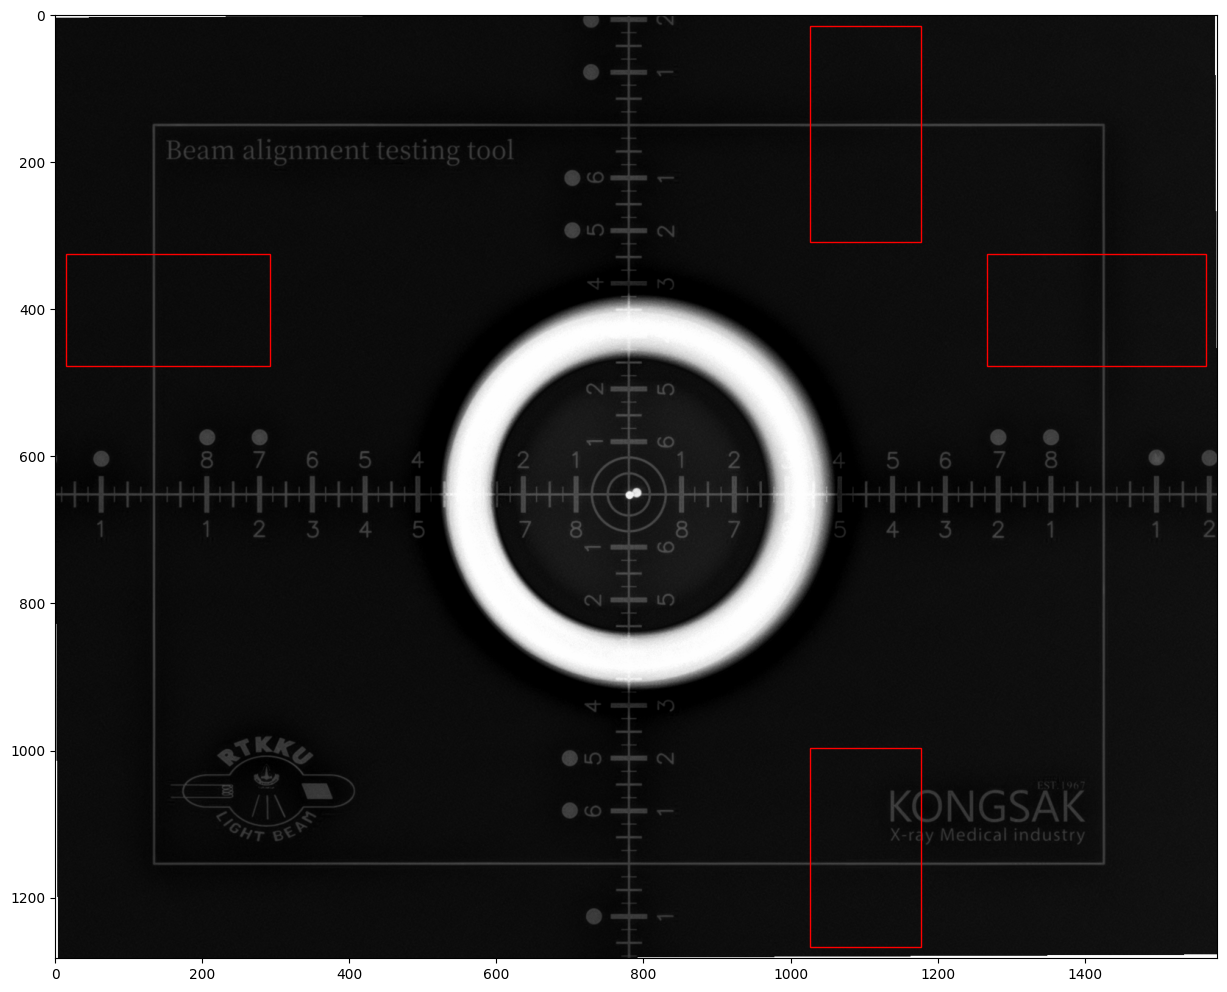

In [349]:
plt.figure(figsize=(15, 15))
for (top_left_point, bottom_right_point) in v:
    ax = plt.gca()
    display(rotate_img, True)
    (x, y), w, h = top_left_point, bottom_right_point[0]-top_left_point[0], bottom_right_point[1]-top_left_point[1]
    rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [350]:
def get_crop_area(positions, arr):
    """
    for left, right, top, bottom
    get crop area pixels from the top_left_point, bottom_right_point
    """

    top_left_point, bottom_right_point = positions[0]
    left_focus = arr[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]

    top_left_point, bottom_right_point = positions[1]
    right_focus = arr[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]

    top_left_point, bottom_right_point = positions[2]
    top_focus = arr[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]

    top_left_point, bottom_right_point = positions[3]
    bottom_focus = arr[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]

    return [left_focus, right_focus, top_focus, bottom_focus]

In [403]:
def bounder_percentile(avg_edge, q=99):
    """
    fin boundery of values of average edge 
    """
    ts = np.percentile(avg_edge, q=q)
    print(q)
    first_pos, last_pos = None, None
    # find first pos
    for pos, val in enumerate(avg_edge) :
        if val >= ts :
            first_pos = pos
            break

    # find last pos
    n = len(avg_edge)
    for pos, val in enumerate(avg_edge[::-1]) :
        if val >= ts :
            last_pos = n-pos-1
            break

    return first_pos, last_pos

In [459]:
def central_diff(pixels, by_x, visualize=True):
    """
    find most difference position
    by_x(True, False) = (x, y)
    """
    if by_x:
        # fininte difference by cols
        nrows, ncols = pixels.shape
        edge_pixels = [] 
        h = 1 # distance between the two pixels being compared
        for r_idx in range(nrows) :
            edge_pixels_col = []
            for c_idx in range(h, ncols-h) : # ncols-1: becuase c_idx+1 use
                # covert to int: not overflow from negative value
                first_val = int(pixels[r_idx][c_idx-h])
                second_val = int(pixels[r_idx][c_idx+h])
                diff_val = np.abs(first_val - second_val) / (2 * h)
                edge_pixels_col.append(round(diff_val))
            edge_pixels.append(edge_pixels_col)

        edge_pixels = np.array(edge_pixels)
        med_edge = np.median(edge_pixels, axis=0)
        first_pos, last_pos = bounder_percentile(med_edge)
        avg_pos = round((first_pos + last_pos) / 2)
        edge_pos = avg_pos + 1

        if visualize:
            _, axs = plt.subplots(2, 1, figsize=(12, 12)) 
            plt.subplot(2, 1, 1)
            plt.plot(np.average(pixels, axis=0), c="blue")
            f_pos = first_pos + 1
            l_pos = last_pos + 1
            edge_pos = avg_pos + 1
            plt.title(f"edge position at {edge_pos}")
            axs[0].plot(np.average(pixels, axis=0))
            axs[0].axvline(x=edge_pos, linestyle="--", c="red", label="Edge Position")
            axs[0].axvline(x=f_pos, linestyle="--", c="violet", label="First Position")
            axs[0].axvline(x=l_pos, linestyle="--", c="k", label="Last Position")
            axs[0].set_title(f"Edge position at {edge_pos}")
            axs[0].grid(True)
            axs[0].set_xlabel("Location")
            axs[0].set_ylabel("Pixel-Value")
            axs[0].legend()

            # Display the image in the second subplot
            im = axs[1].imshow(pixels, cmap="gray", aspect="auto")  # Set aspect to 'auto'
            axs[1].axvline(x=edge_pos, linestyle="--", c="red")
            axs[1].axvline(x=f_pos, linestyle="--", c="violet")
            axs[1].axvline(x=l_pos, linestyle="--", c="k")
            axs[1].set_xlabel("Location")

            # Ensure the x-axis limits match
            for ax in axs:
                ax.set_xlim([0, pixels.shape[1]])  # Use the same x-axis limit

            plt.tight_layout()
            plt.show()

        return edge_pos

99


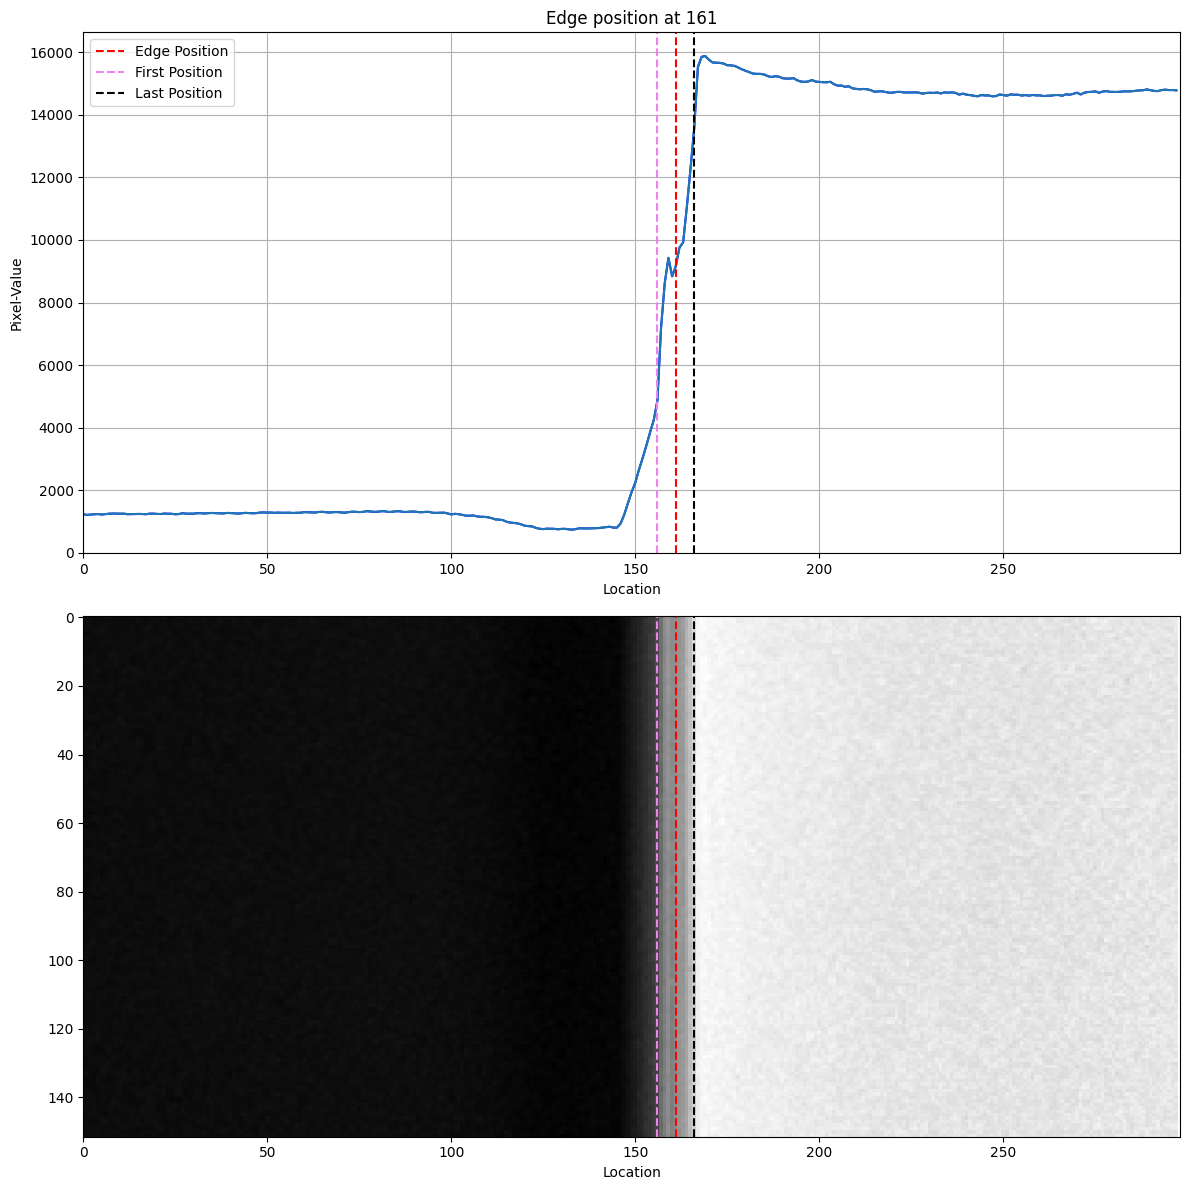

161

In [460]:
central_diff(get_crop_area(v, rotate_img2)[1], by_x=True)